# Comparison of the Different Merge_After
- Number of initial chains: 7
- Vary merge_after parameter (1, 2, 3, 4) (as 5 is mean and median, majority of chains still have merge during generation)

In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from utils import *

In [3]:
experiments = [f"m1_{i}" for i in range(1, 5)] + [f"m2_{i}" for i in range(1, 5)] + [f"n1_{i}" for i in range(1, 5)] +  [f"n2_{i}" for i in range(1, 5)]
complete_folders = check_existing_folders(experiments)


Folders with all required files:
['m1_1', 'm1_2', 'm1_3', 'm1_4', 'm2_1', 'm2_2', 'm2_3', 'm2_4', 'n1_1', 'n1_2', 'n1_3', 'n1_4', 'n2_1', 'n2_2', 'n2_3', 'n2_4']


In [4]:
# For paper
plt.rcParams.update({
    "font.size": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 22,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20,
    "legend.title_fontsize": 22,
    "figure.dpi": 300
})

In [5]:
line_color_map = {
    "n1": "#eed202",  # dark yellow
    "n2": "#86b049",  # green
    "m1": "#1f77b4",  # blue
    "m2": "#e377c2",  # magenta
}

In [6]:
def plot_k_curve(metric_file_name="_em_results.jsonl", metric_column=None, metric_name="predicted", ylabel="Score", title=""):
    data = {}

    for exp in experiments:
        if metric_column is None:
            score = compute_accuracy(exp, metric_file_name, metric_name)
        else:
            score = compute_roscoe_metric(exp, metric_file_name, metric_column)

        base = exp[:-2]
        k = int(exp.split("_")[1])
        if base not in data:
            data[base] = {}
        data[base][k] = score

    fig, ax = plt.subplots(figsize=(10, 6))

    for base, k_scores in data.items():
        ks = sorted(k_scores.keys())
        scores = [k_scores[k] for k in ks]
        ax.plot(ks, scores,
                label=base.upper(),
                color=line_color_map.get(base),
                linewidth=3)
        if "n" in base:
            marker_type, marker_size = ("^", 130)
        else:
            marker_type, marker_size = ("x", 130)
        ax.scatter(ks, scores, color=line_color_map.get(base), zorder=5, s=marker_size, marker=marker_type)

    ax.set_xlabel("k")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks([1, 2, 3, 4])
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.6)

    # Legend
    legend_elements = []
    for k in ["n1", "n2", "m1", "m2"]:
        if "n" in k:
            marker, _ = ("^", 130)
        else:
            marker, _ = ("x", 130)
        legend_elements.append(
            Line2D([0], [0],
                   color=line_color_map[k],
                   marker=marker,
                   label=k.upper(),
                   markersize=10,
                   linewidth=3)
        )

    ax.legend(handles=legend_elements, title="Experiment")
    plt.tight_layout()
    plt.show()

### Accuracy of final answer

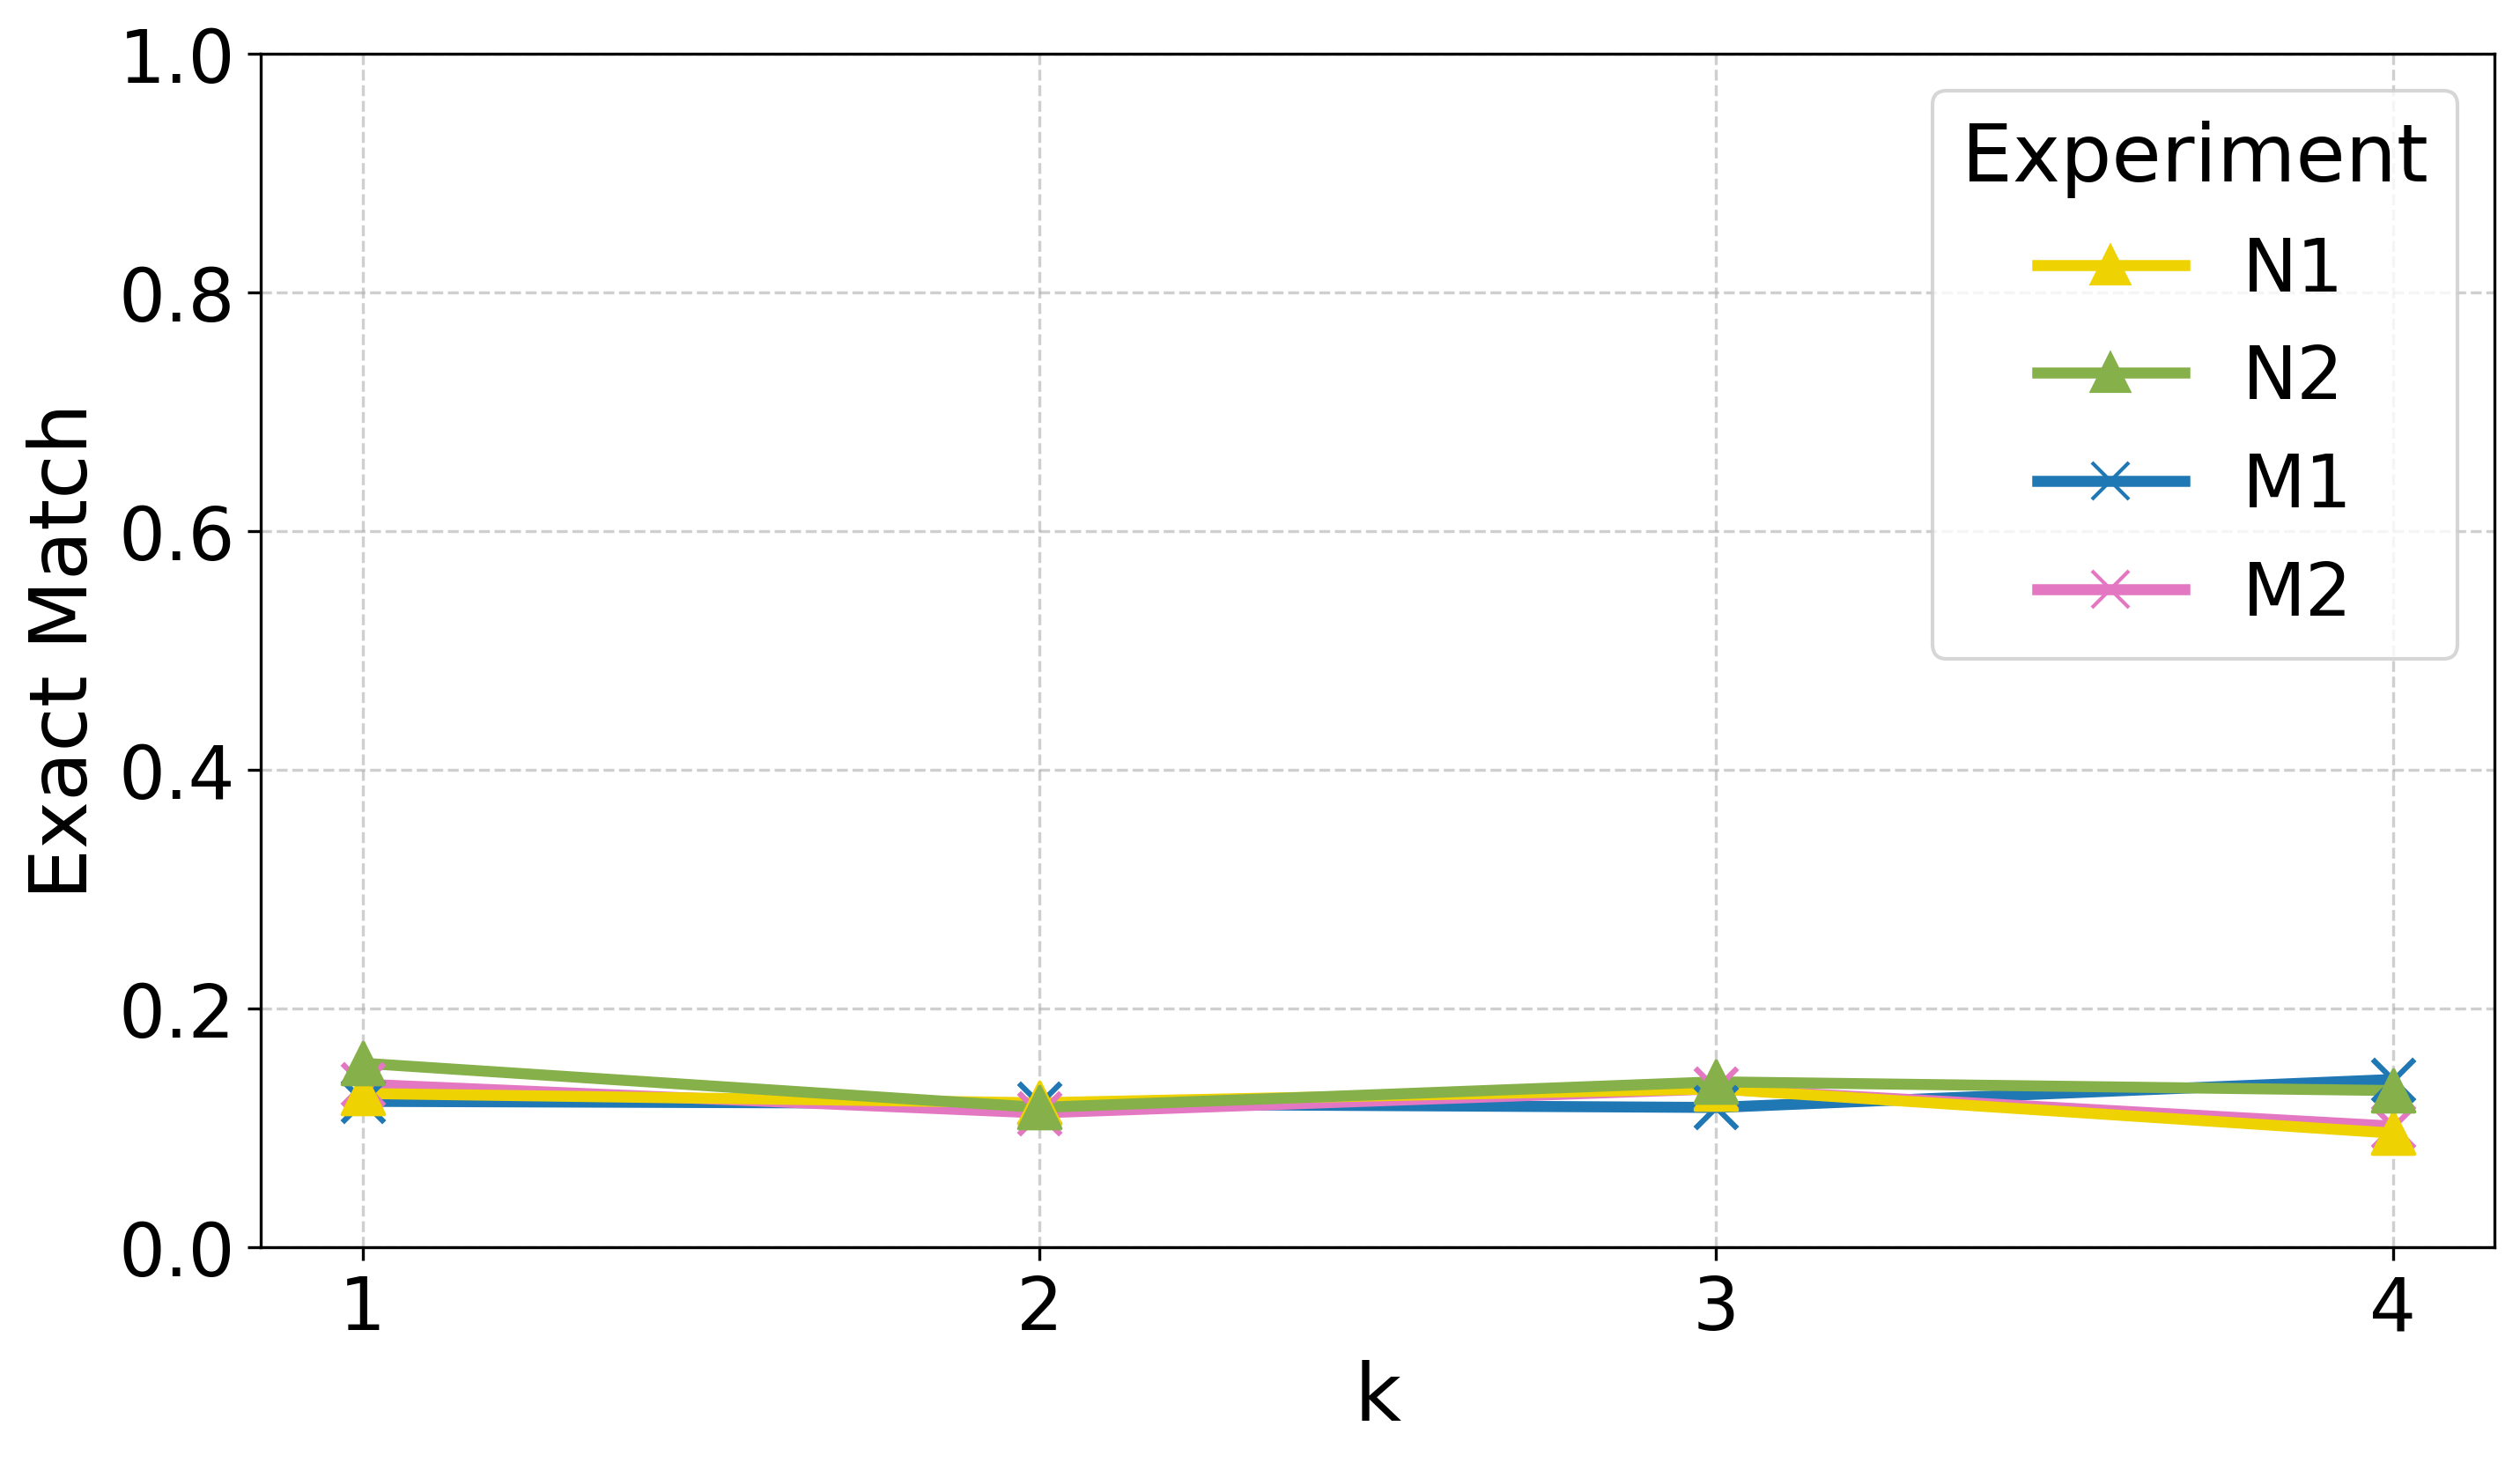

In [7]:
plot_k_curve(metric_file_name="_em_results.jsonl", metric_column=None, metric_name="predicted", ylabel="Exact Match")

### Accuracy of the reasoning process

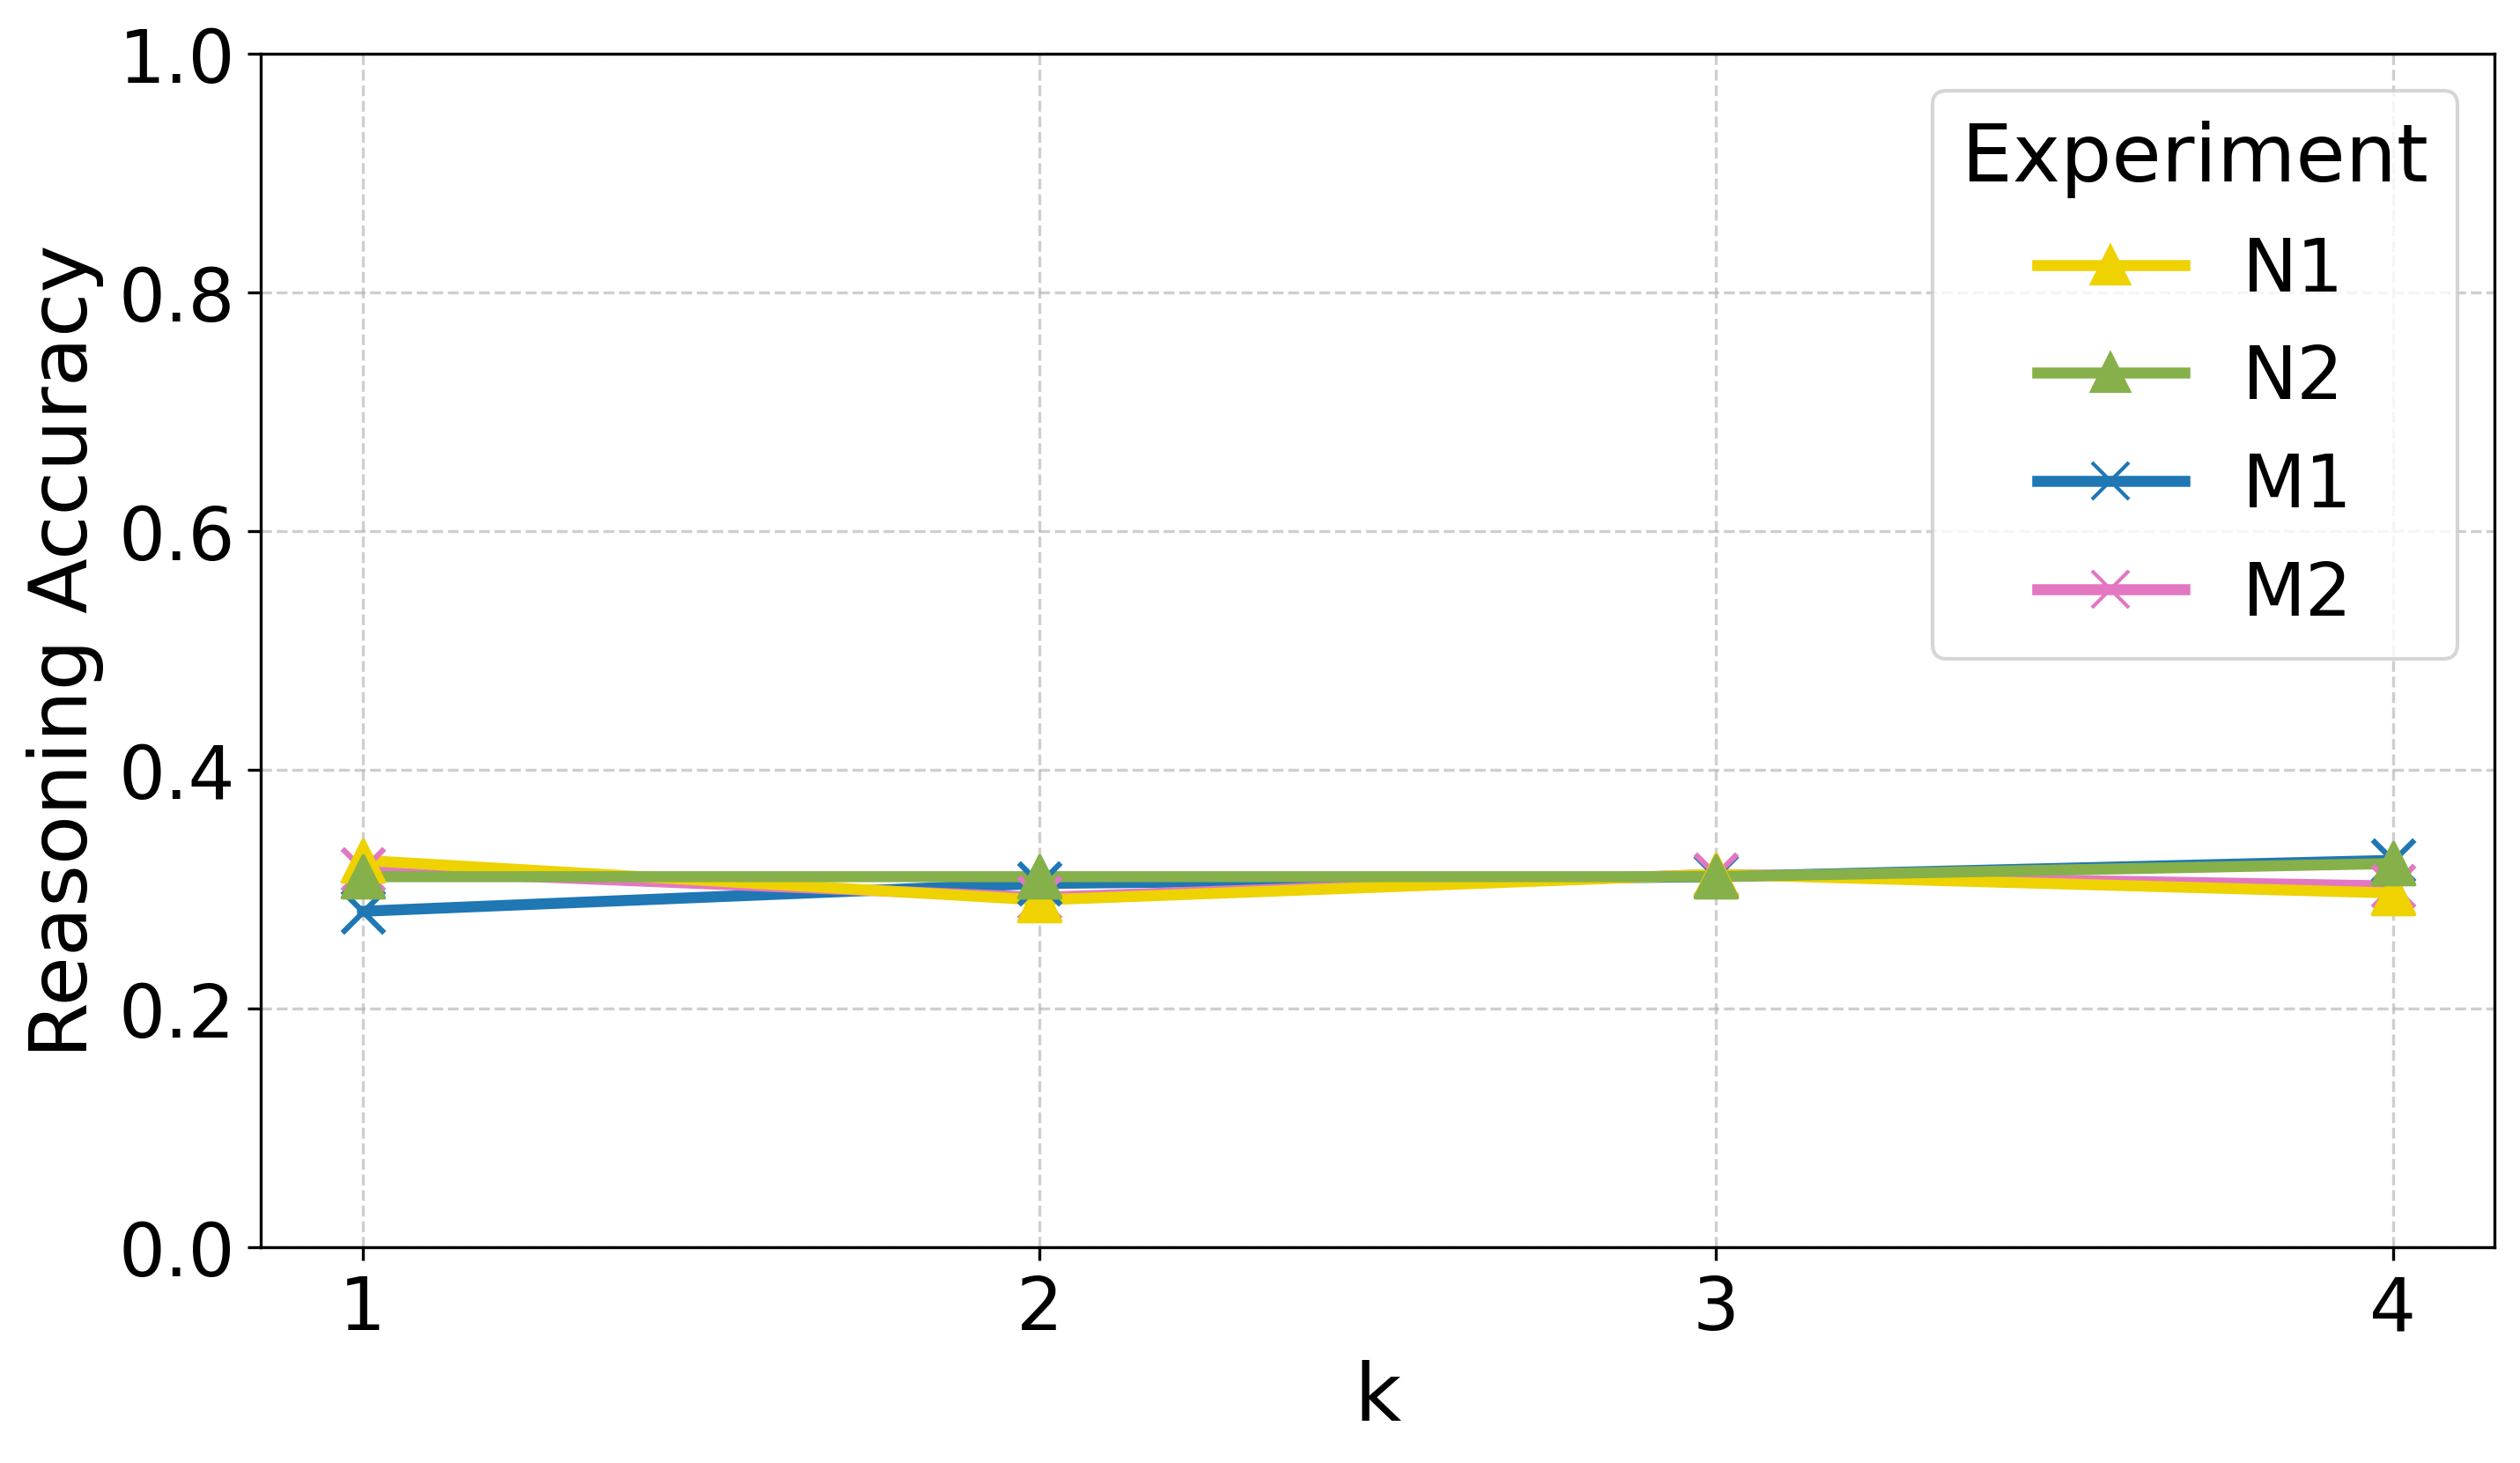

In [8]:
plot_k_curve(metric_file_name="_llm_comparison_results.jsonl", ylabel="Reasoning Accuracy", title="")

### Faithfulness of the final chain

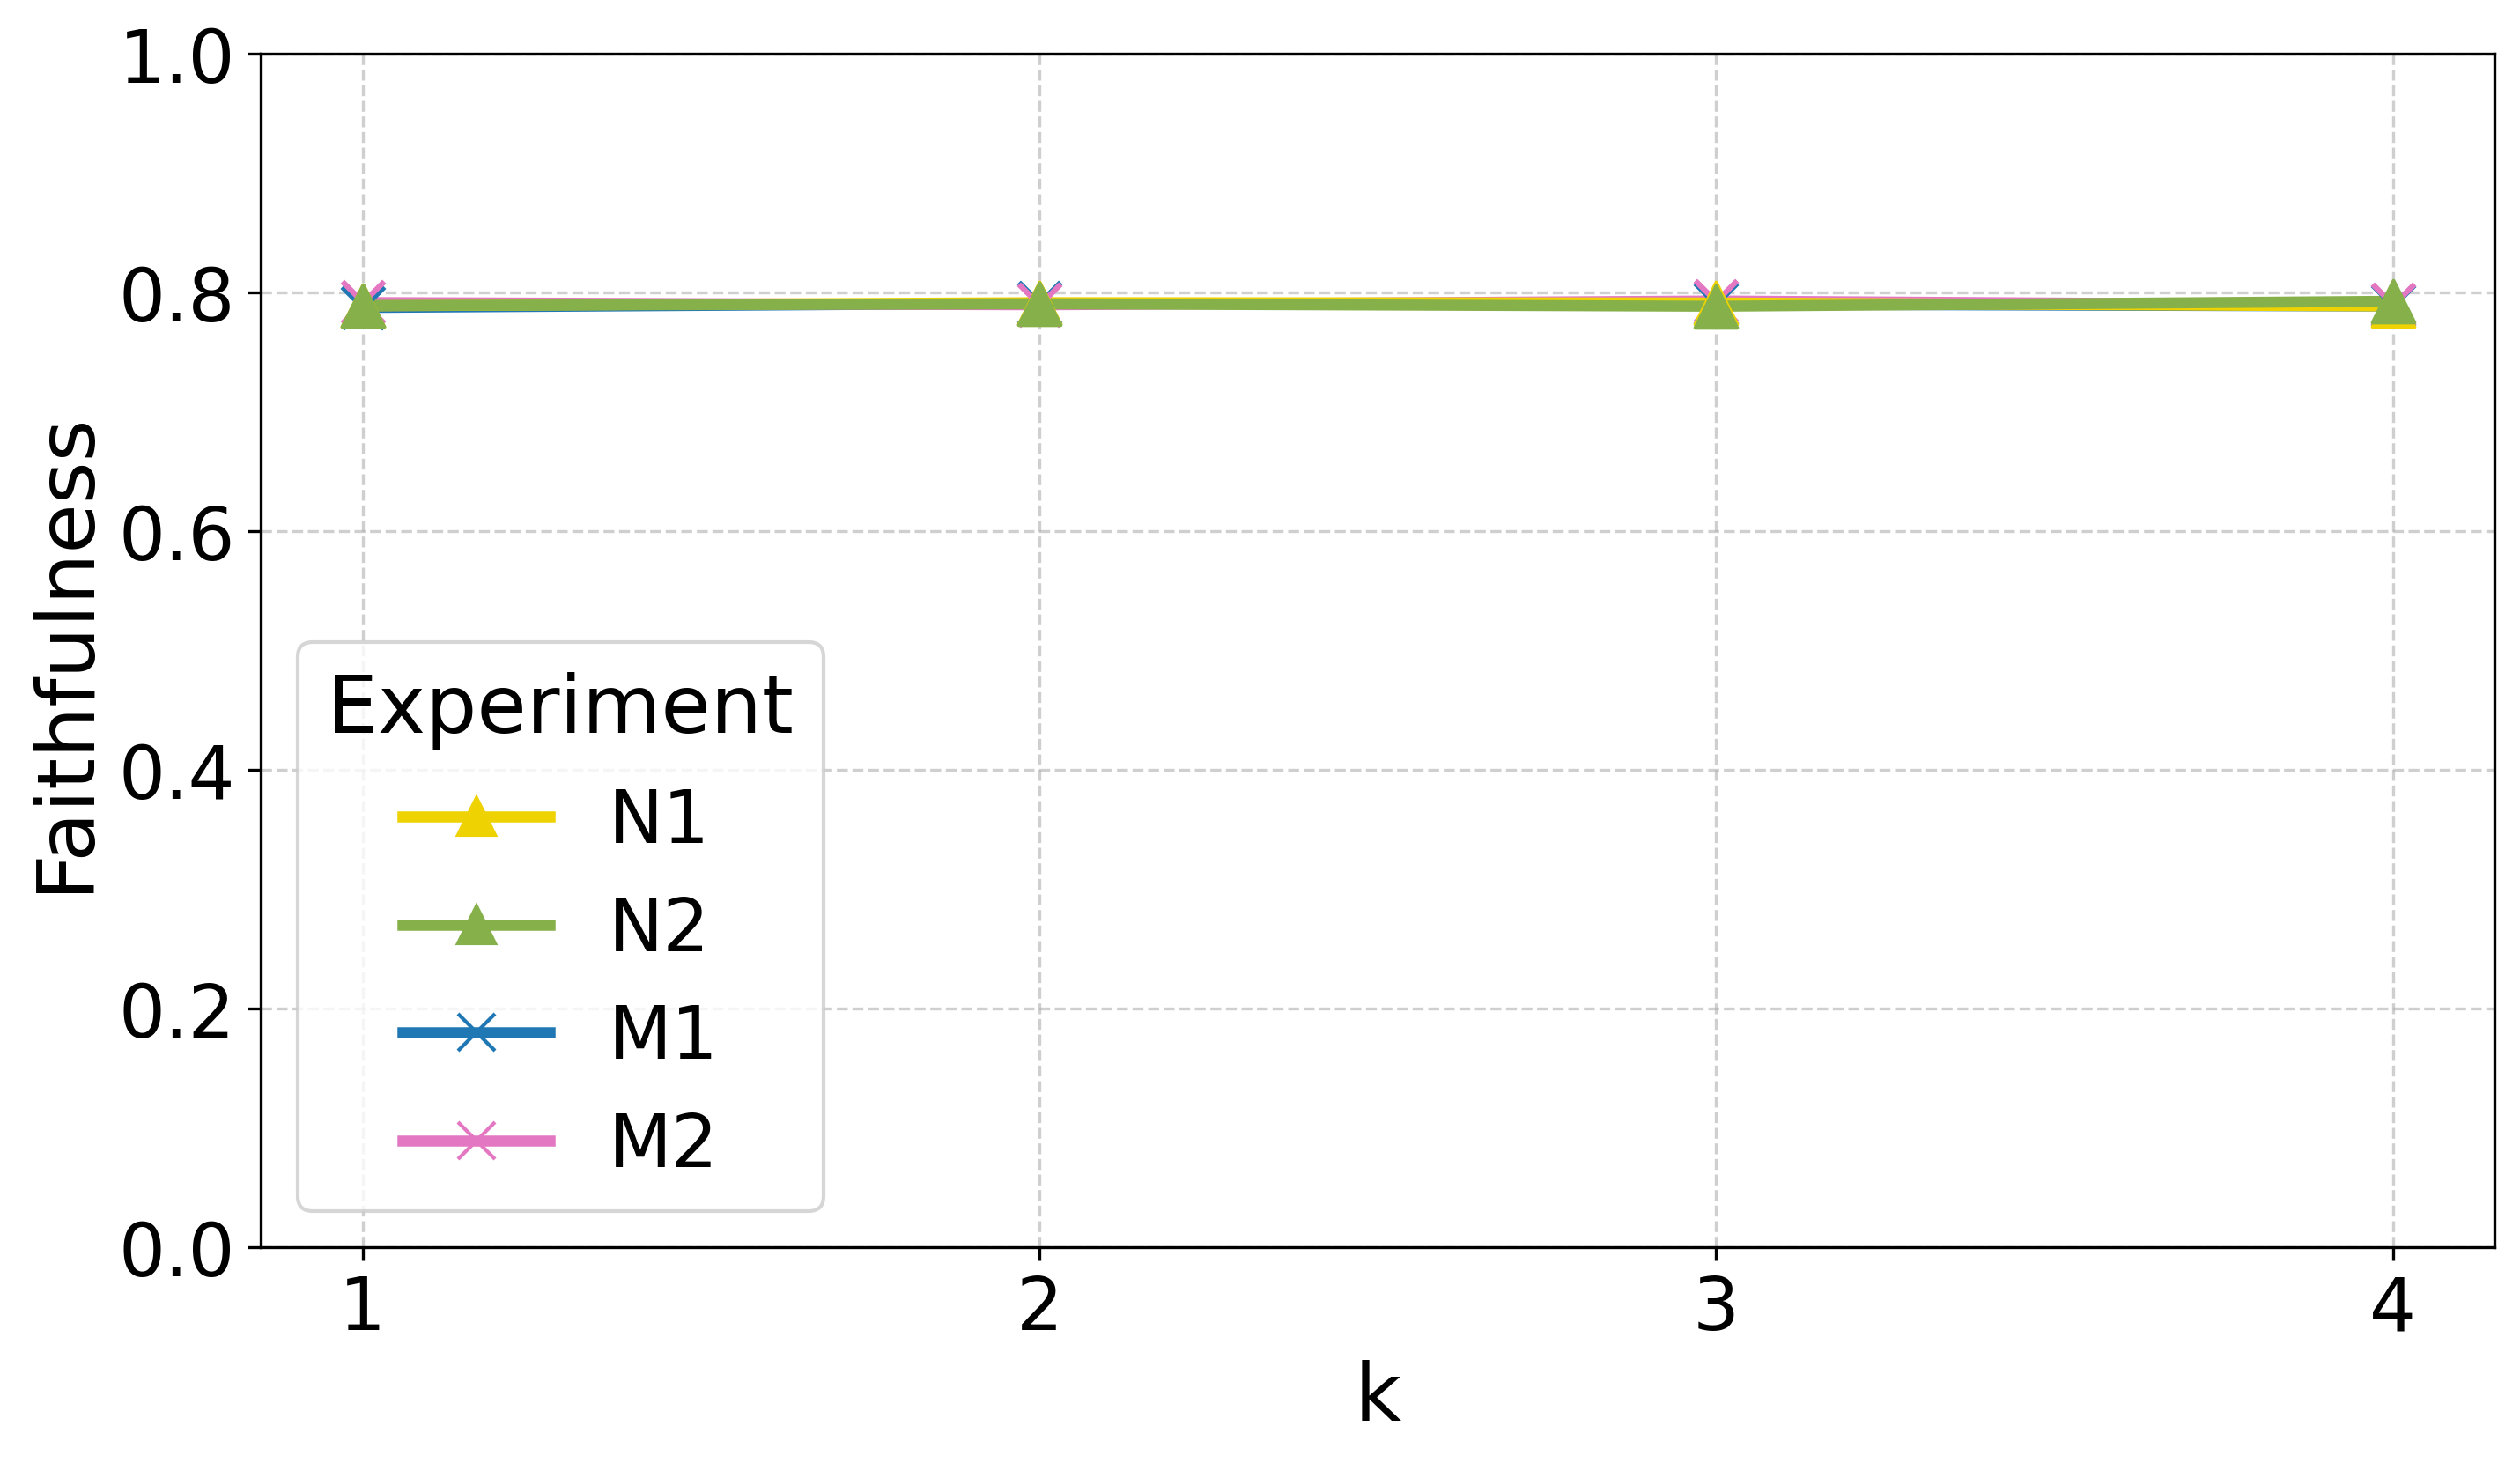

In [9]:
plot_k_curve(metric_file_name="_roscoe_results.tsv", metric_column="faithfulness", ylabel="Faithfulness", title="")

### Other metrics
#### Correctness of Reasoning Process

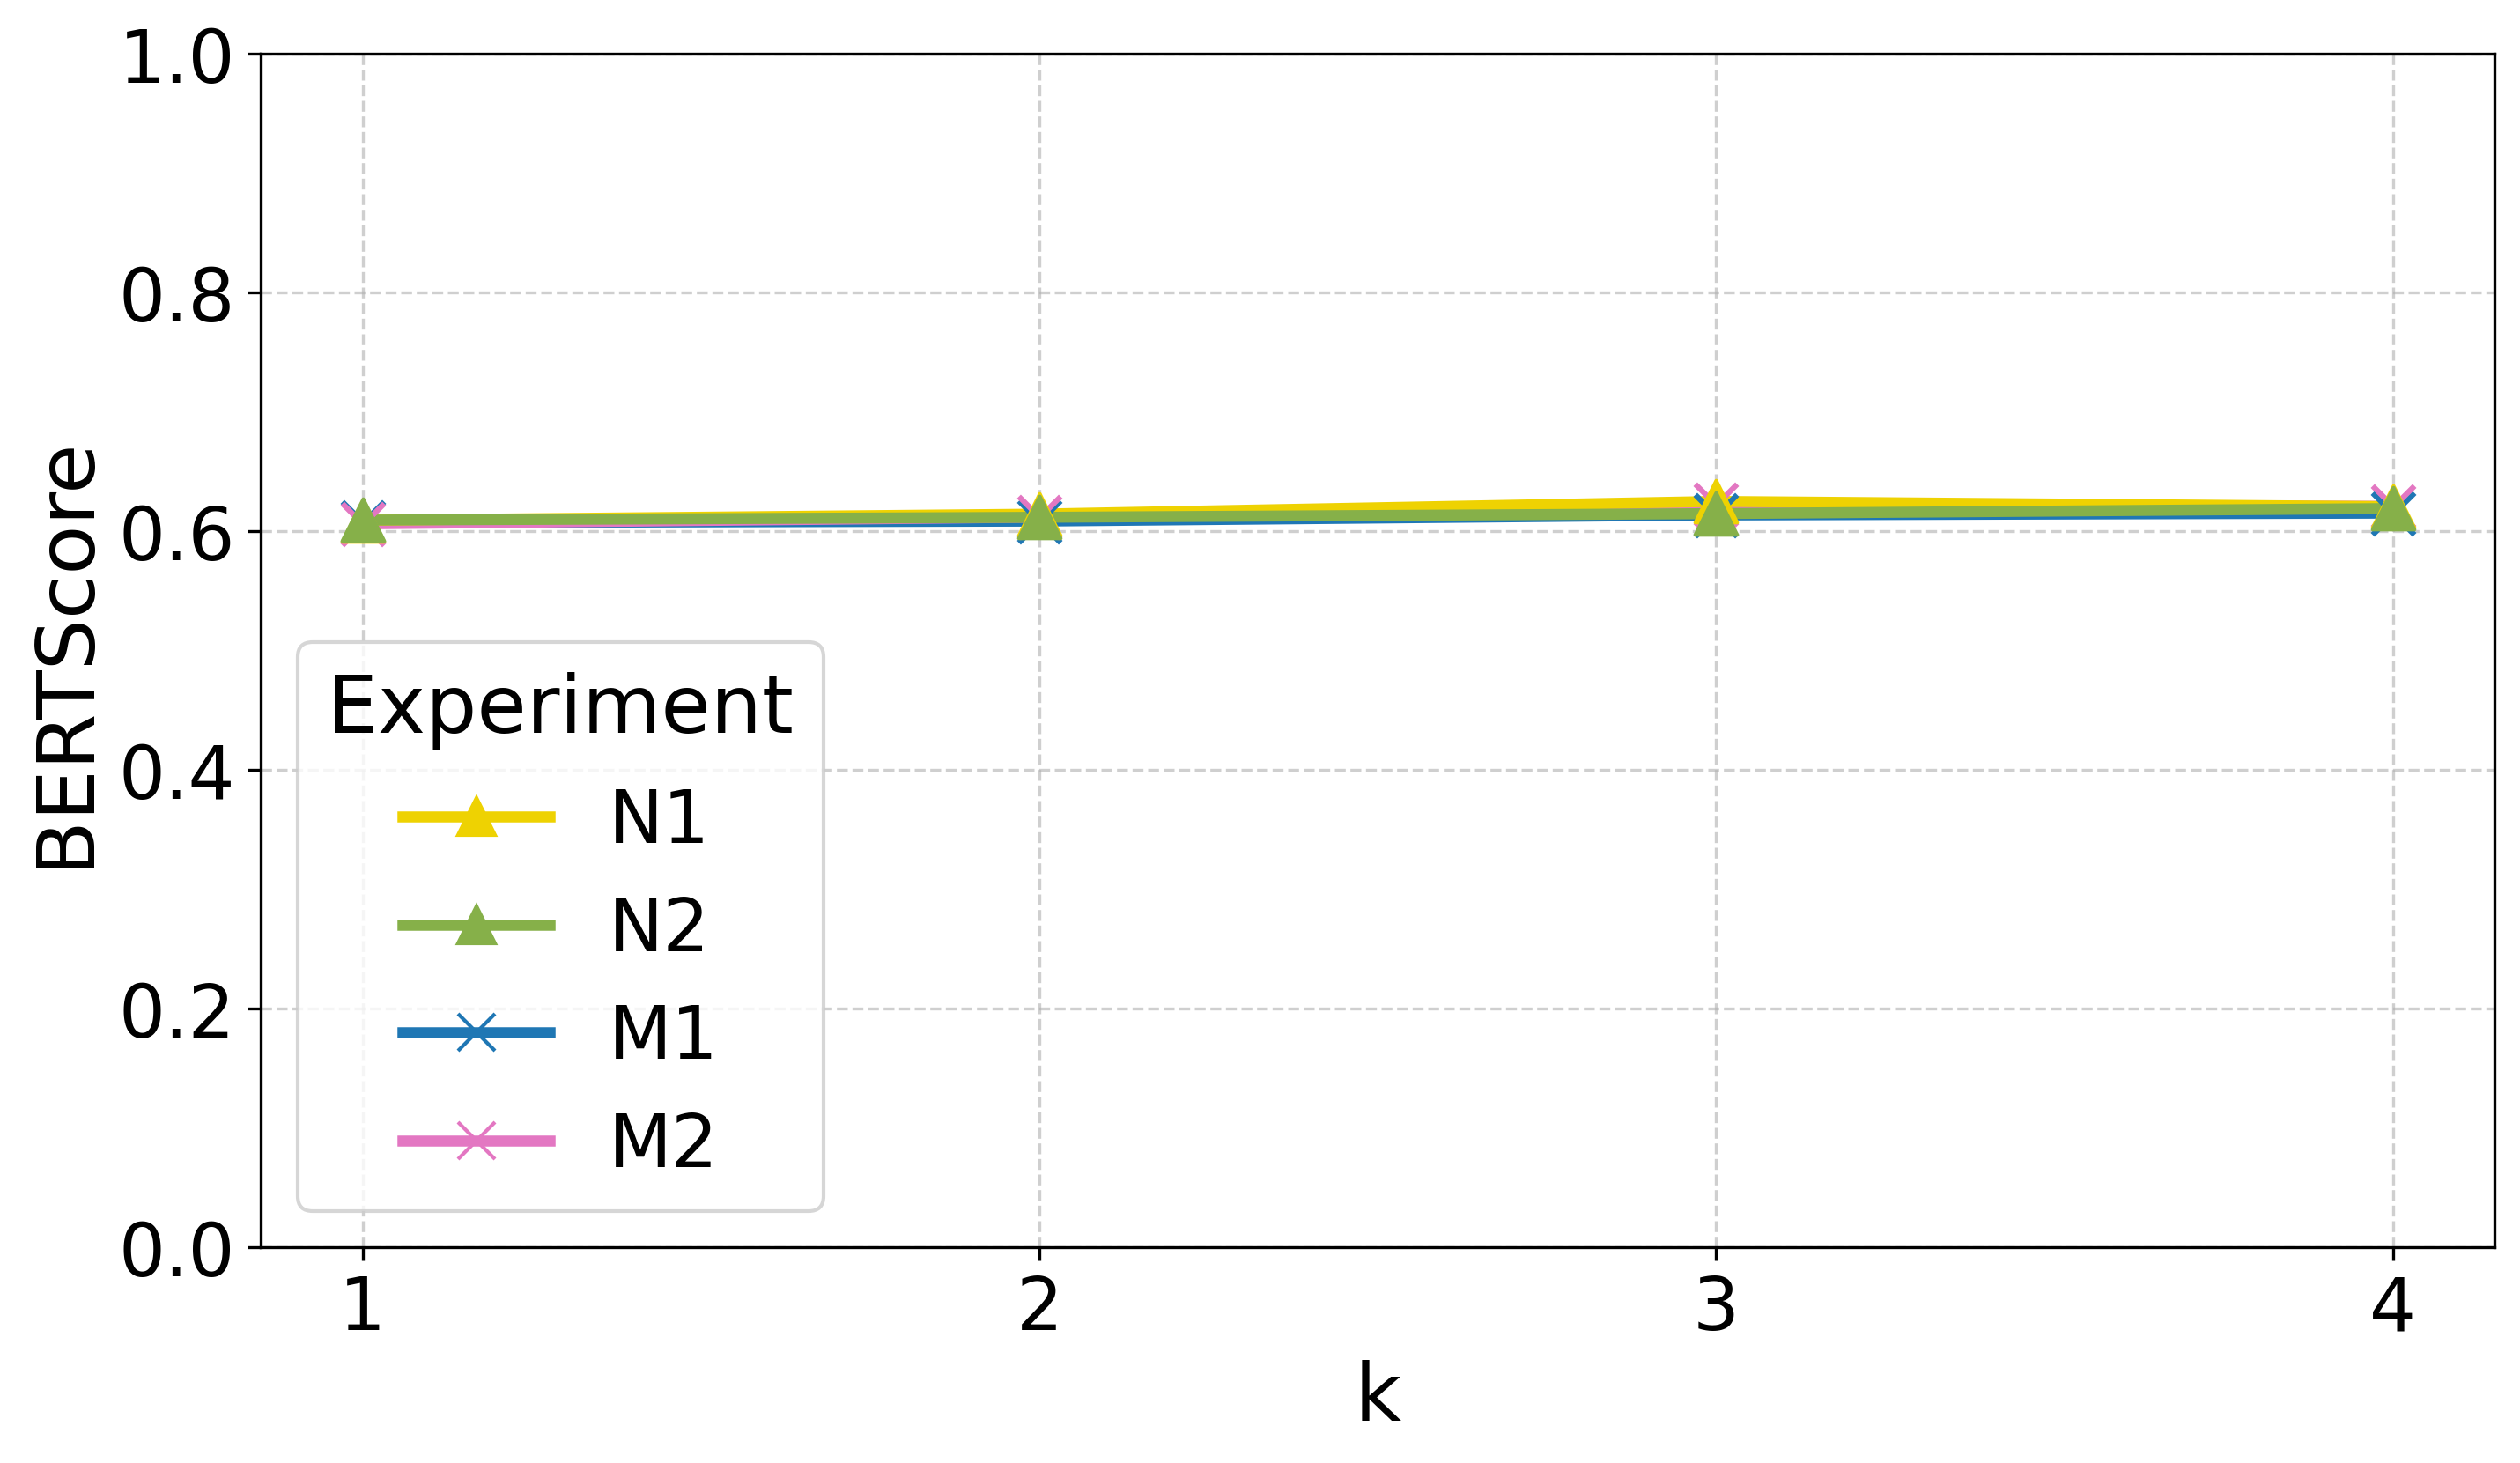

In [10]:
plot_k_curve(metric_file_name="_bert_score_results.jsonl", ylabel="BERTScore", title="", metric_name="similarity")

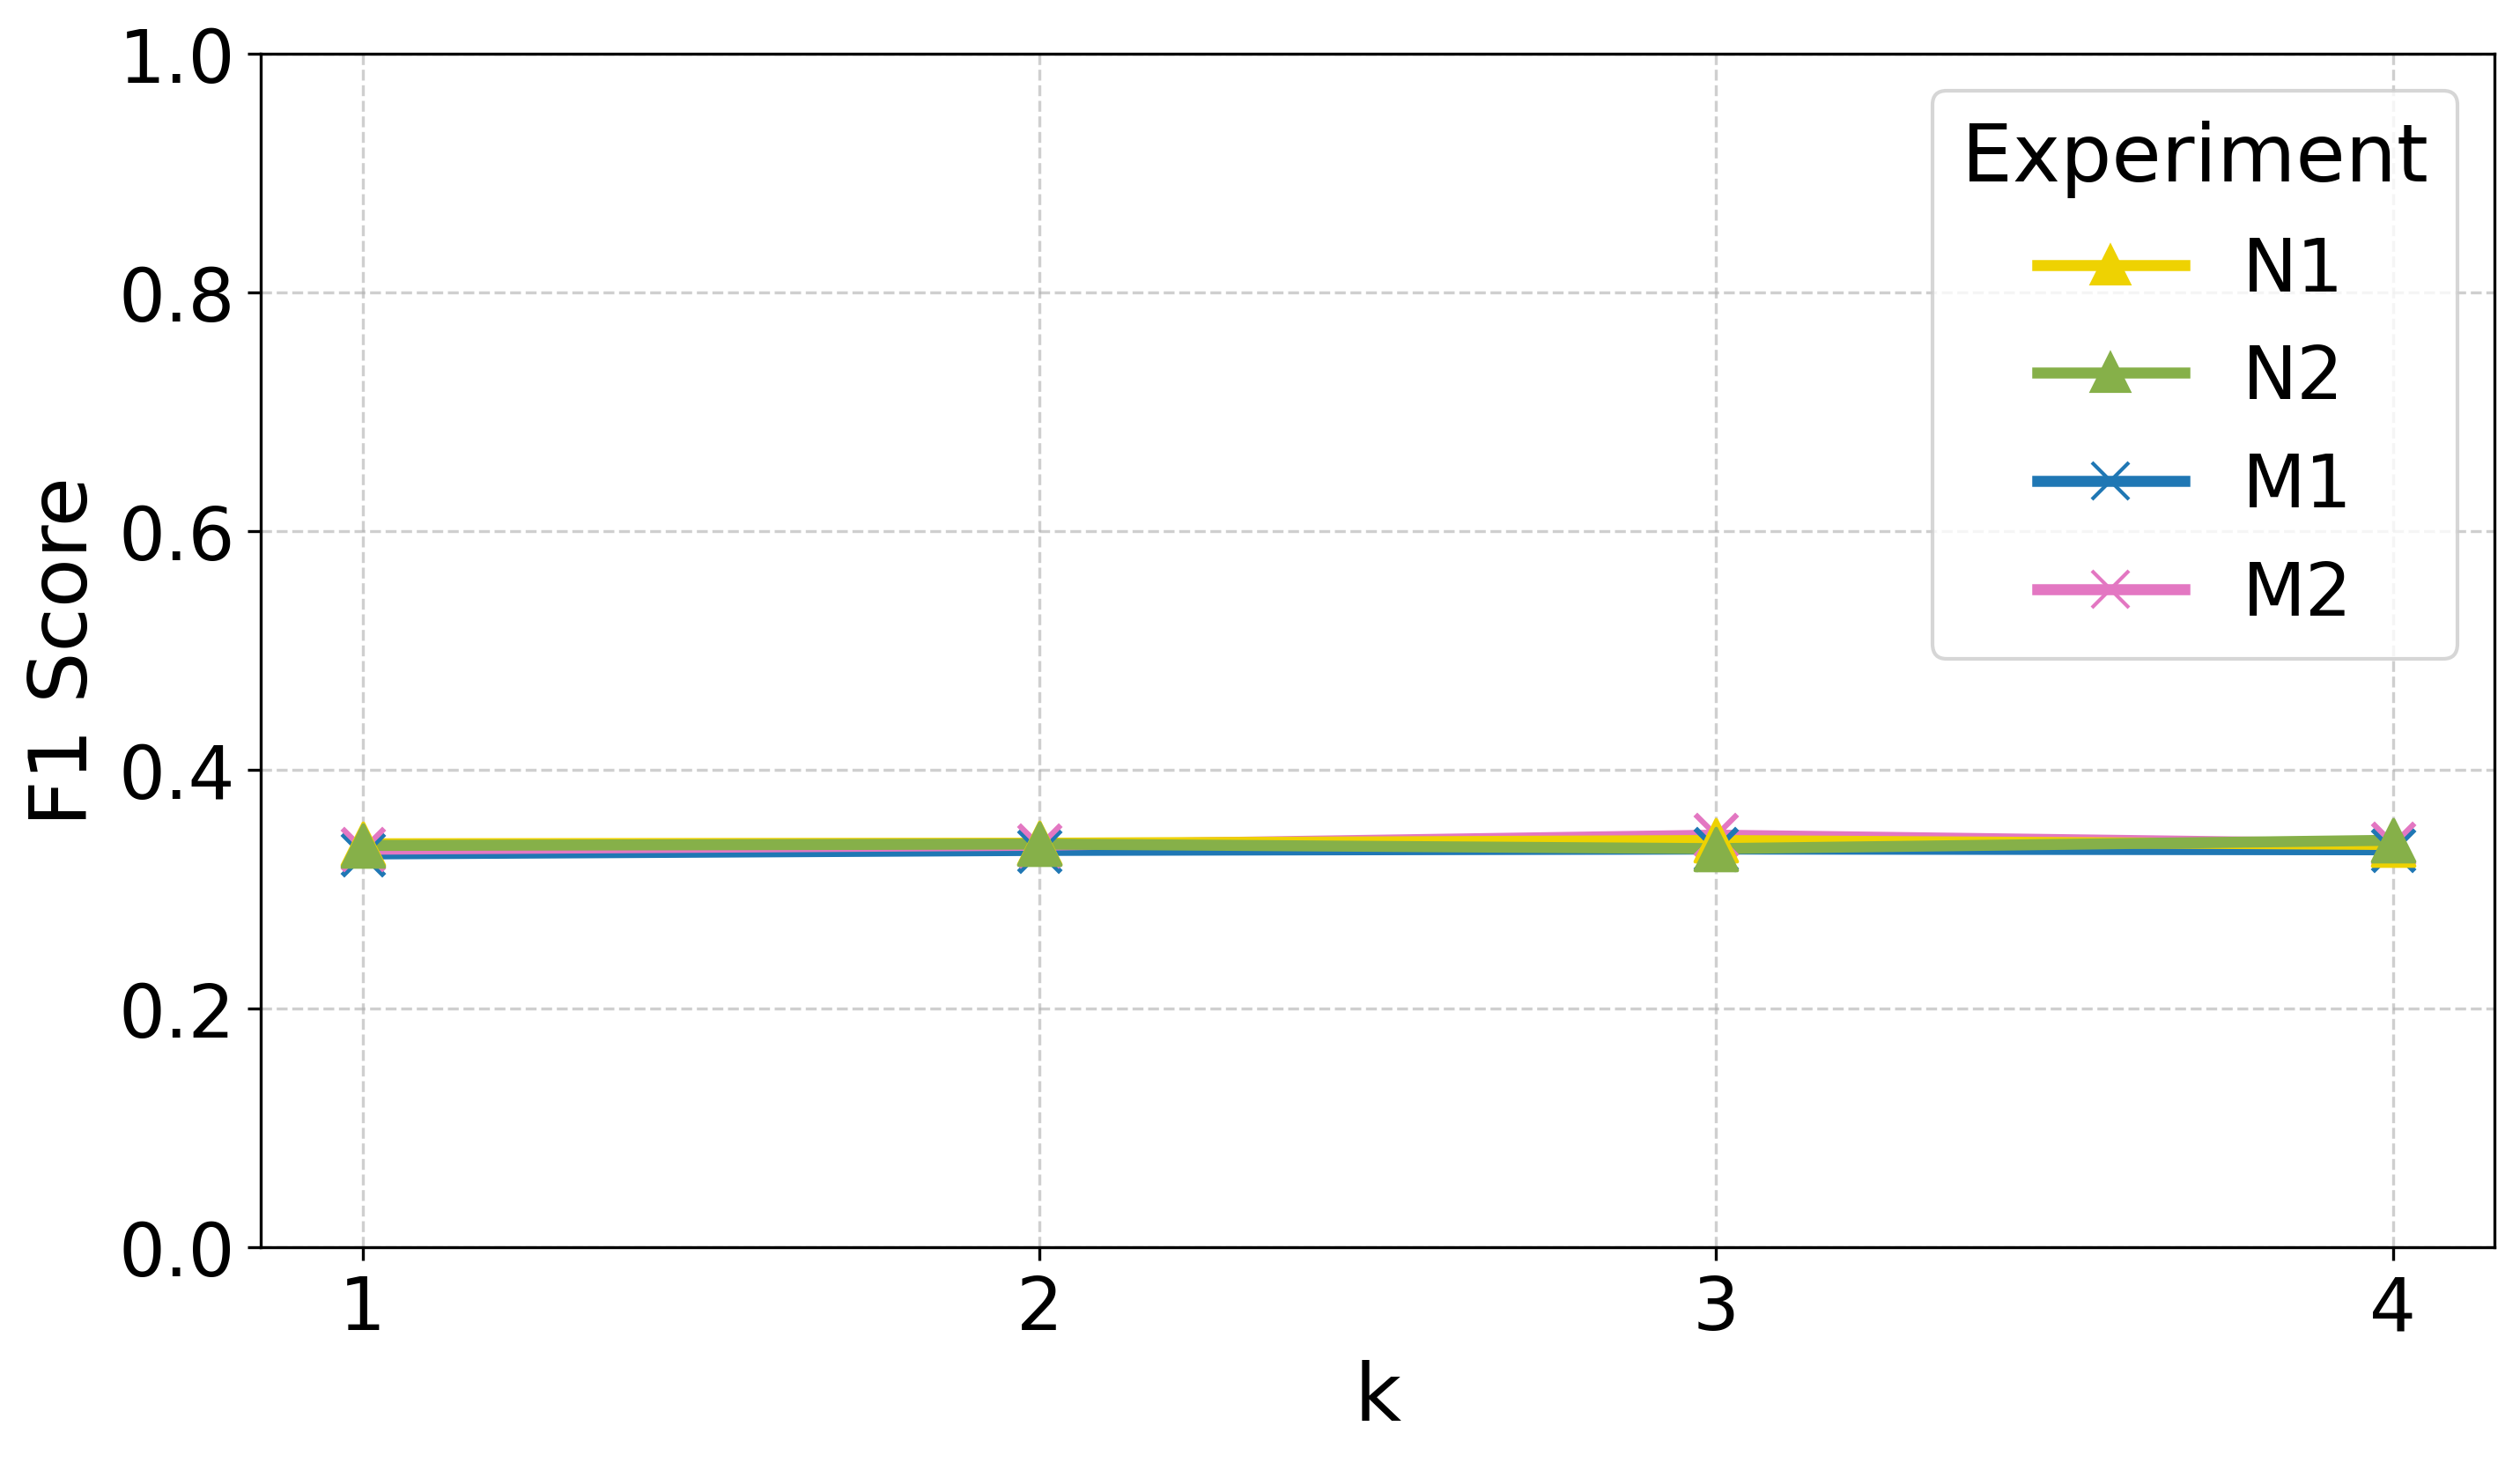

In [11]:
plot_k_curve(metric_file_name="_f1_results.jsonl", ylabel="F1 Score", title="", metric_name="f1")

#### Chain Consistency and Quality

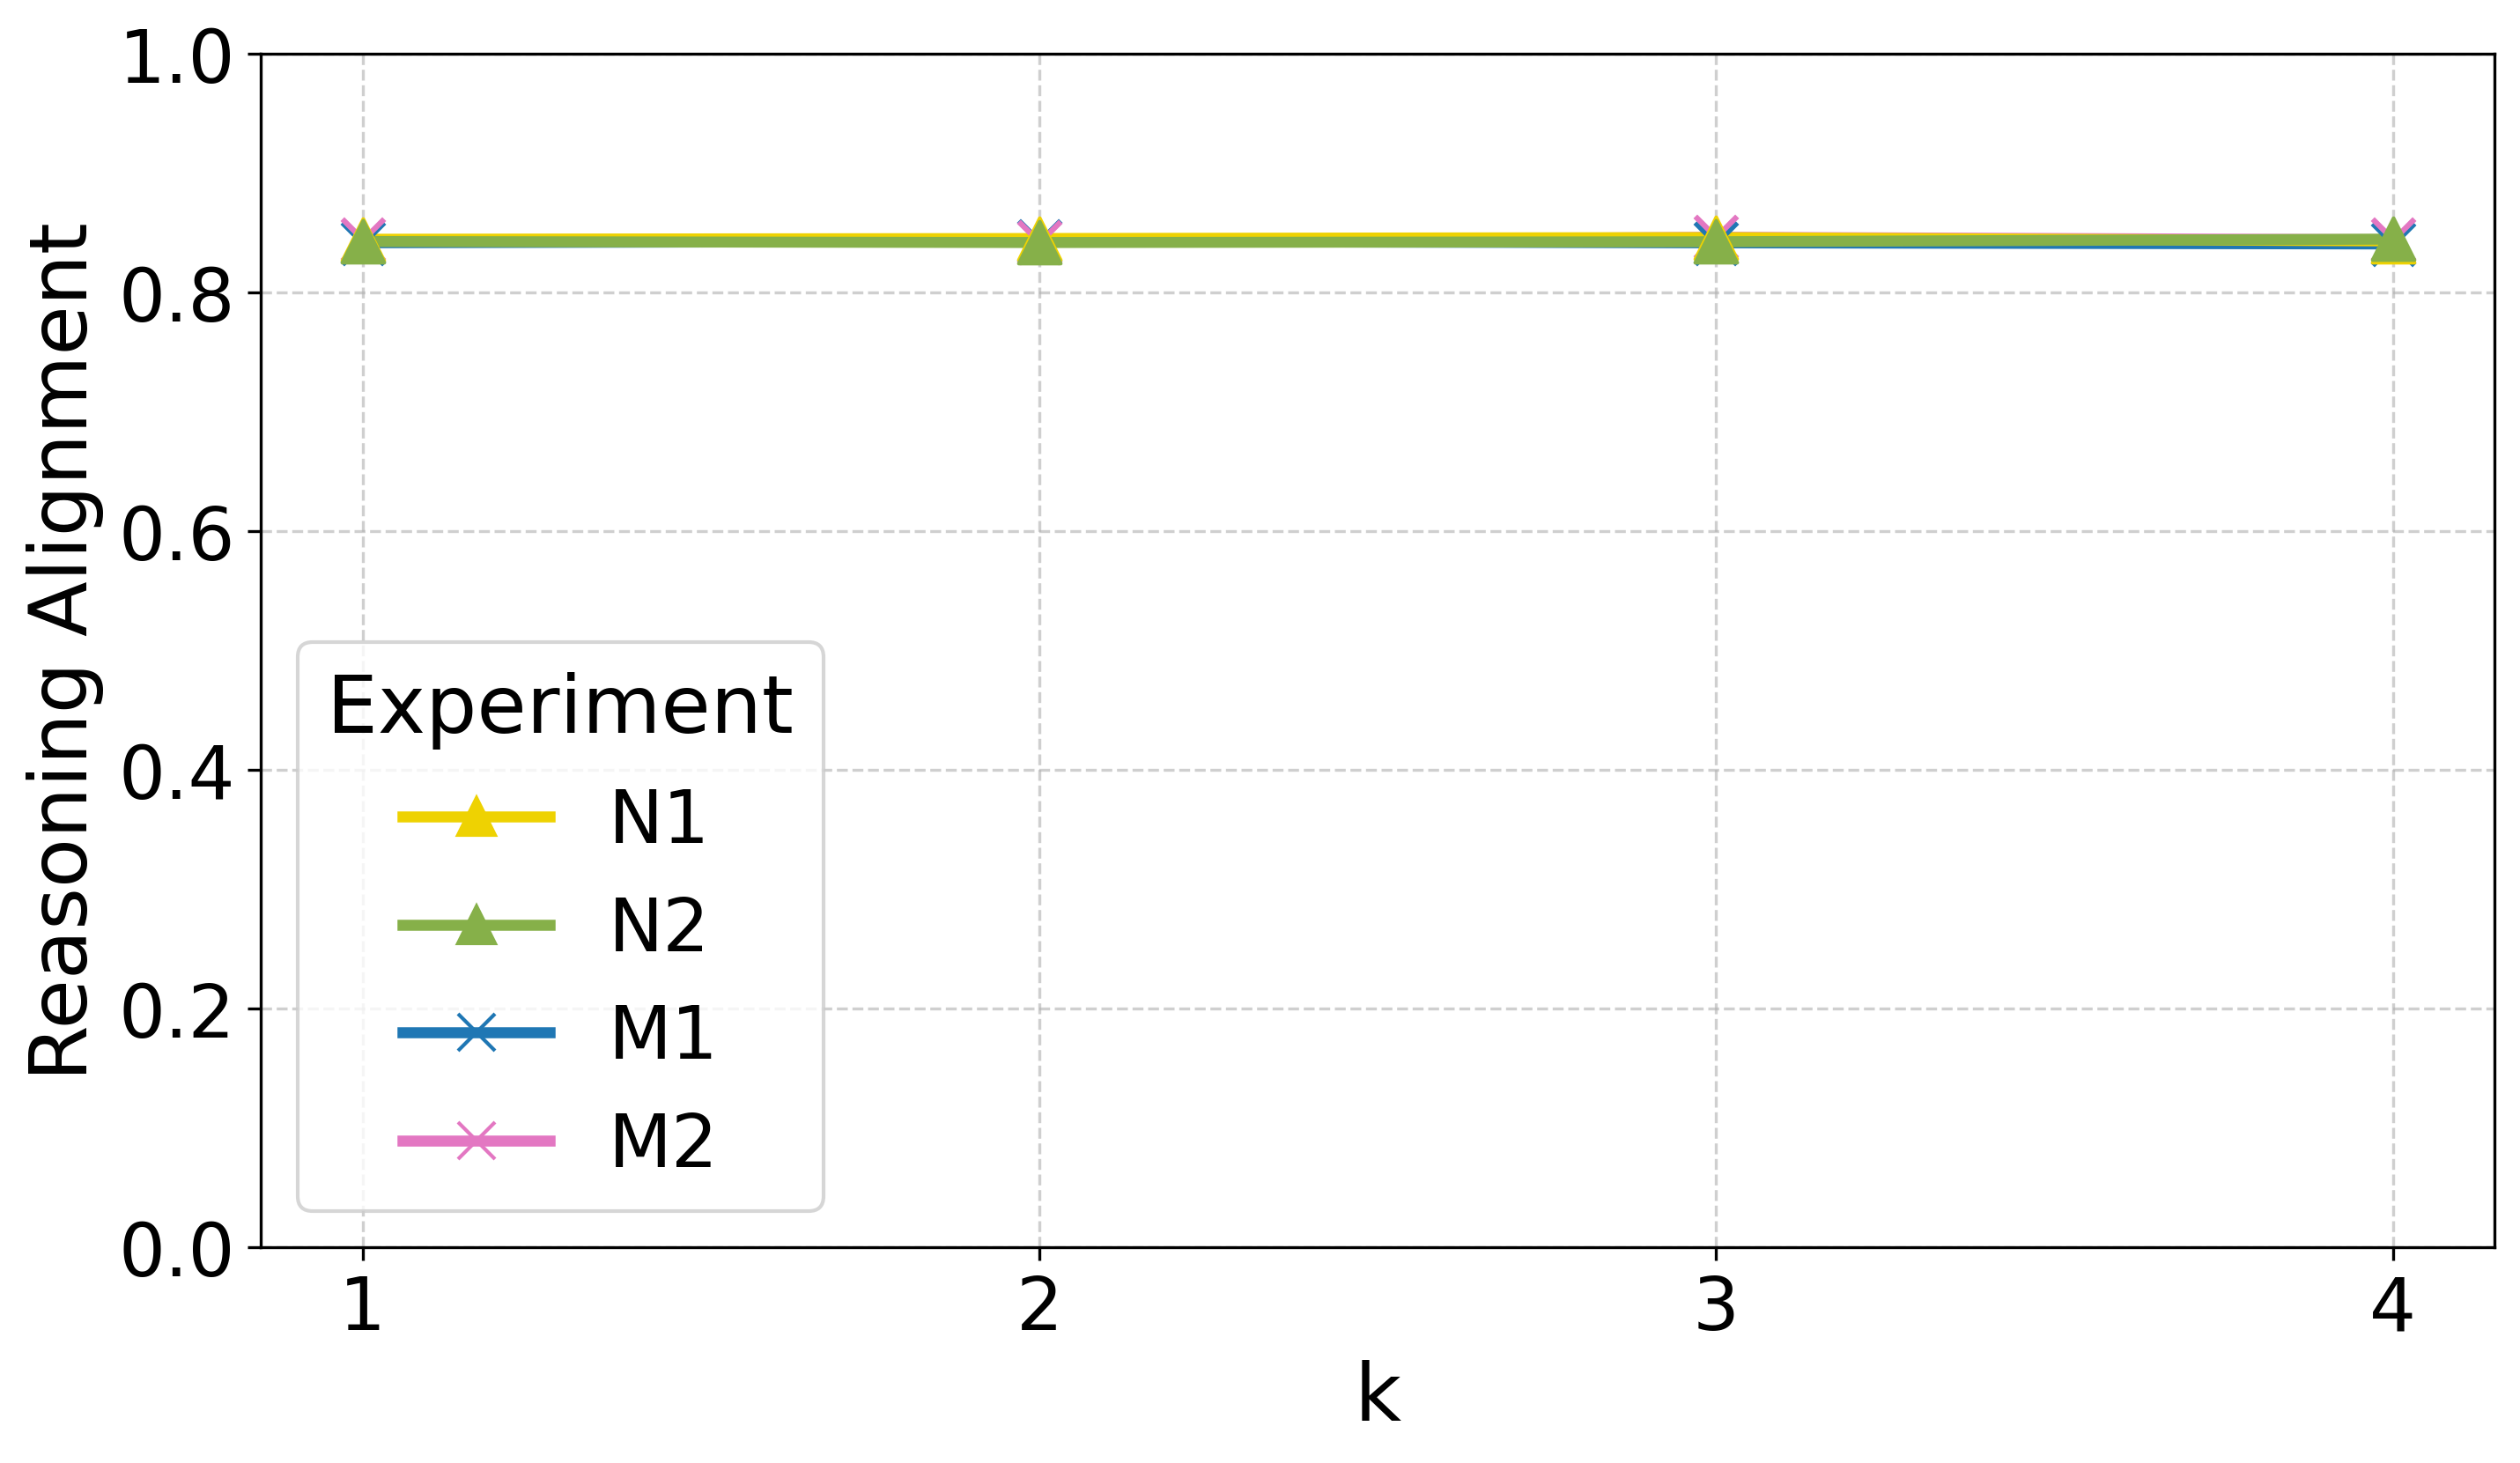

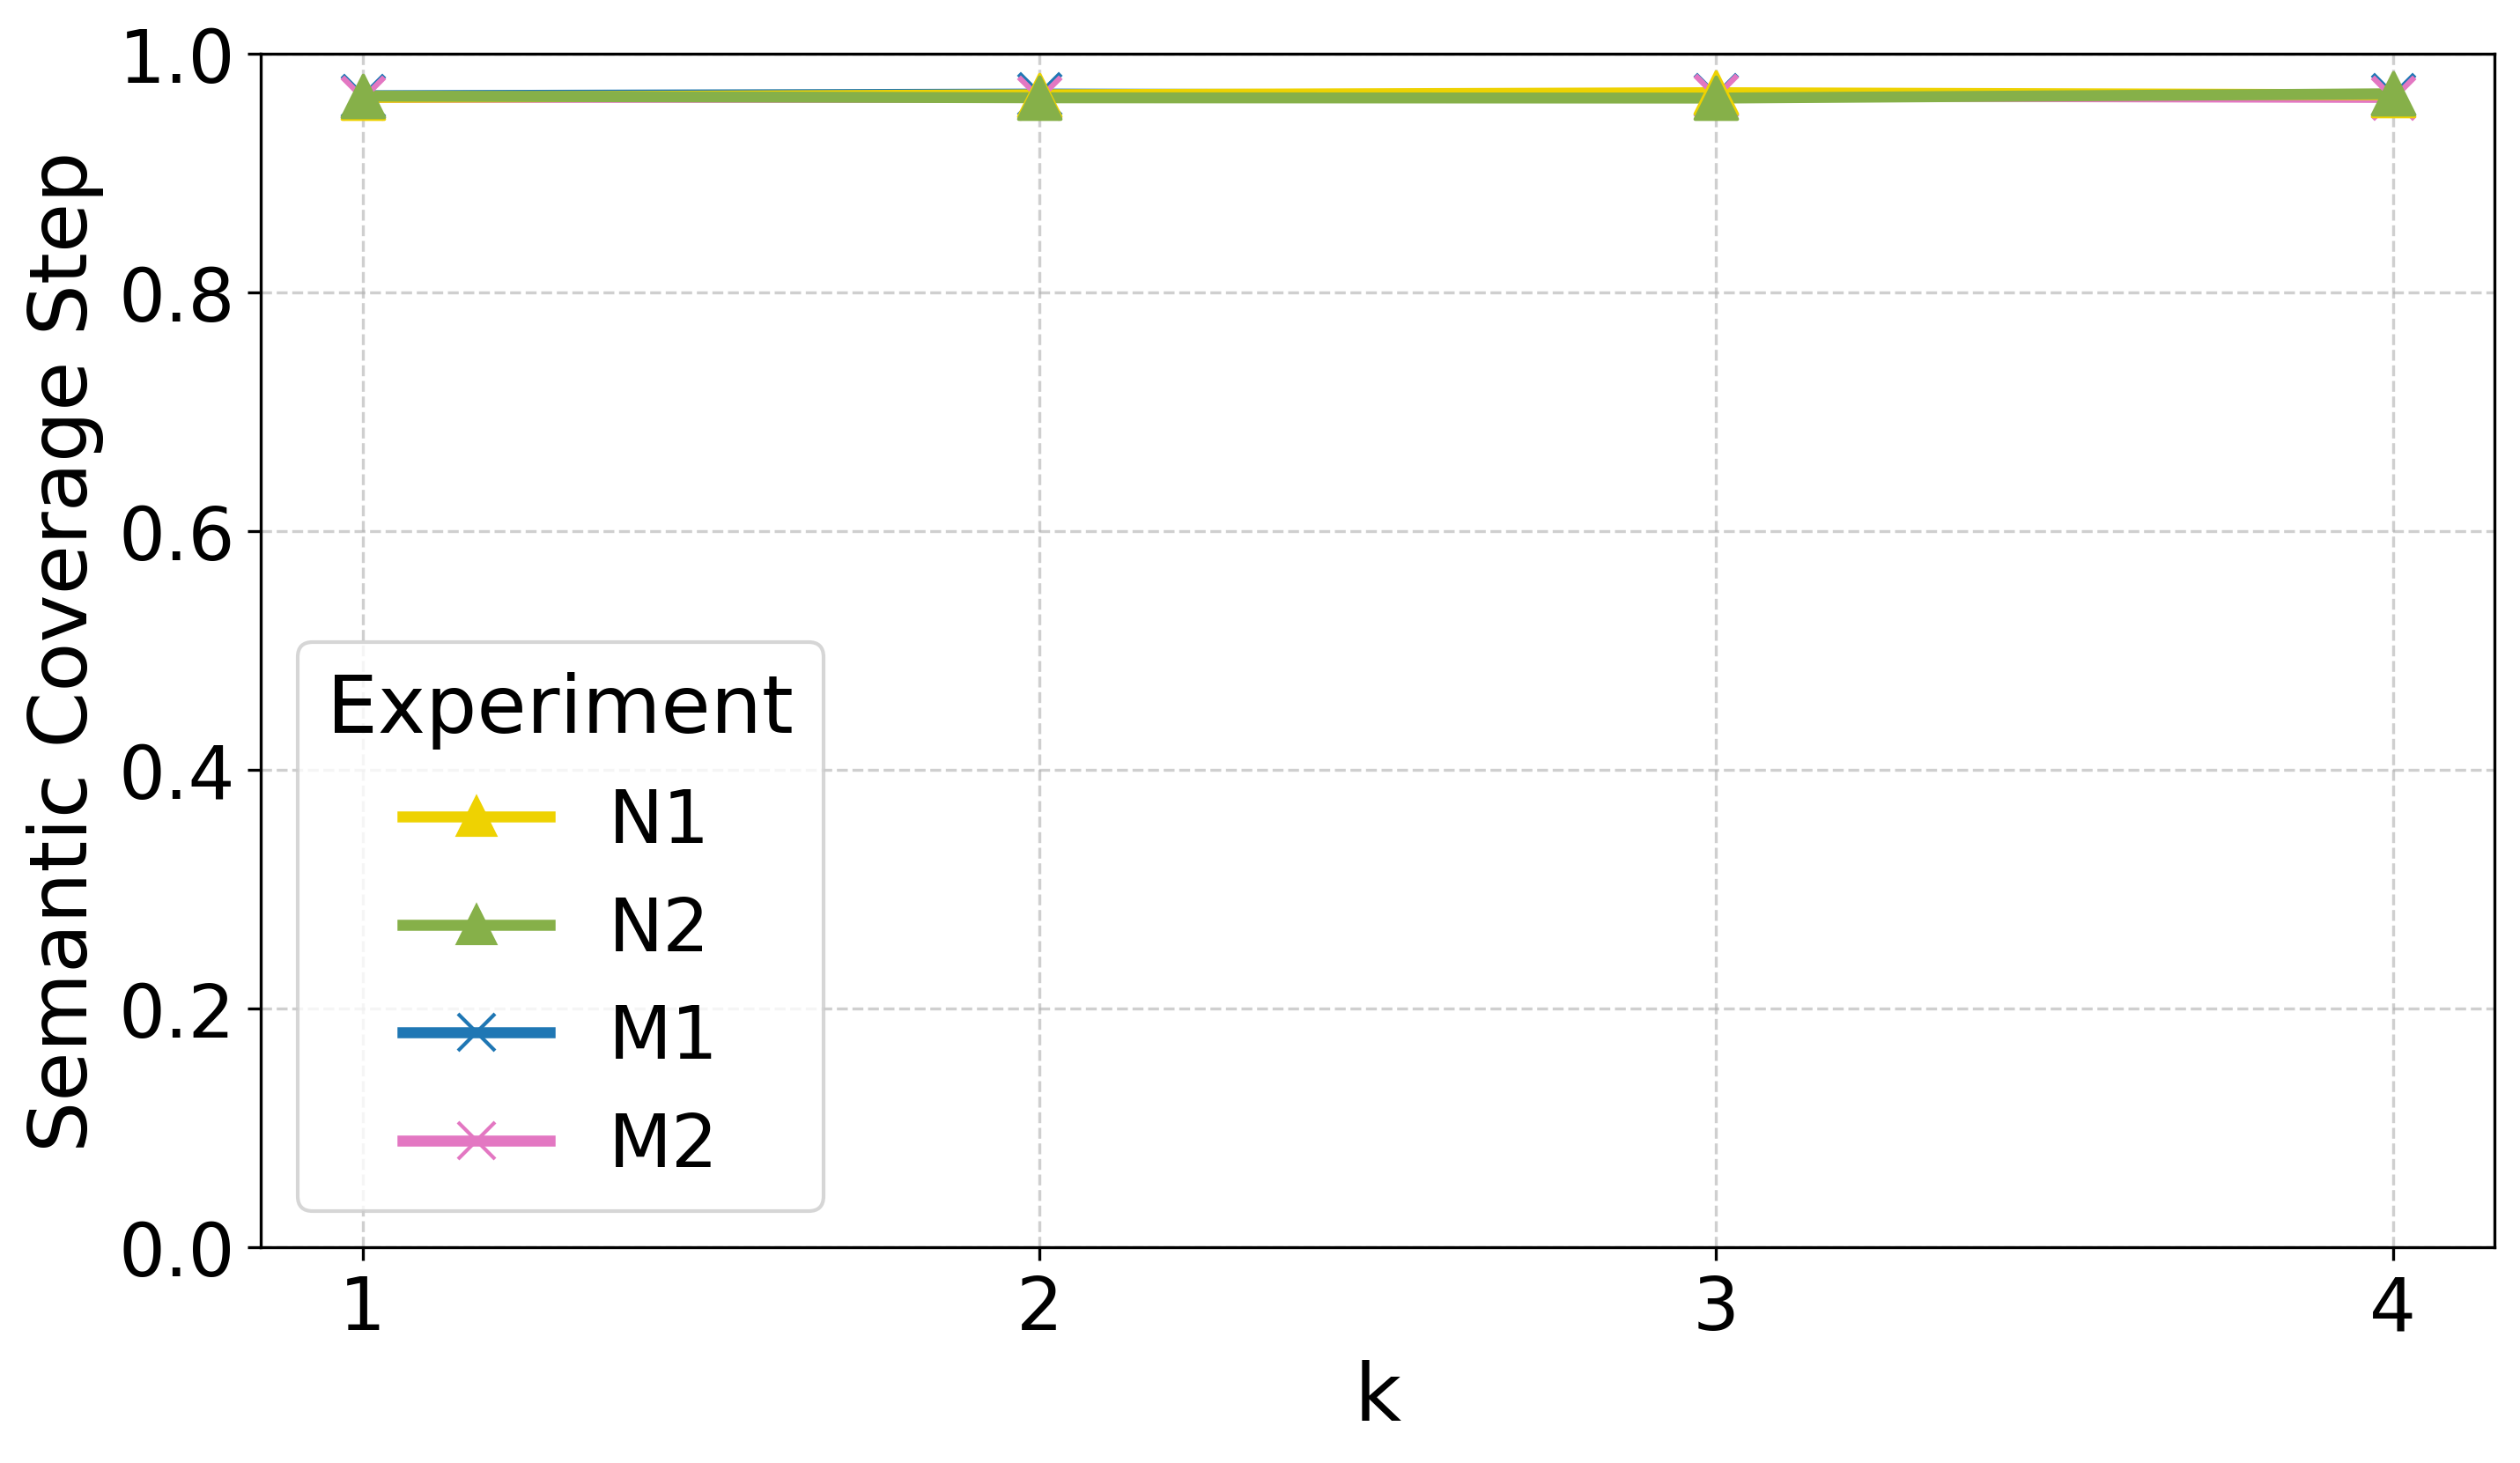

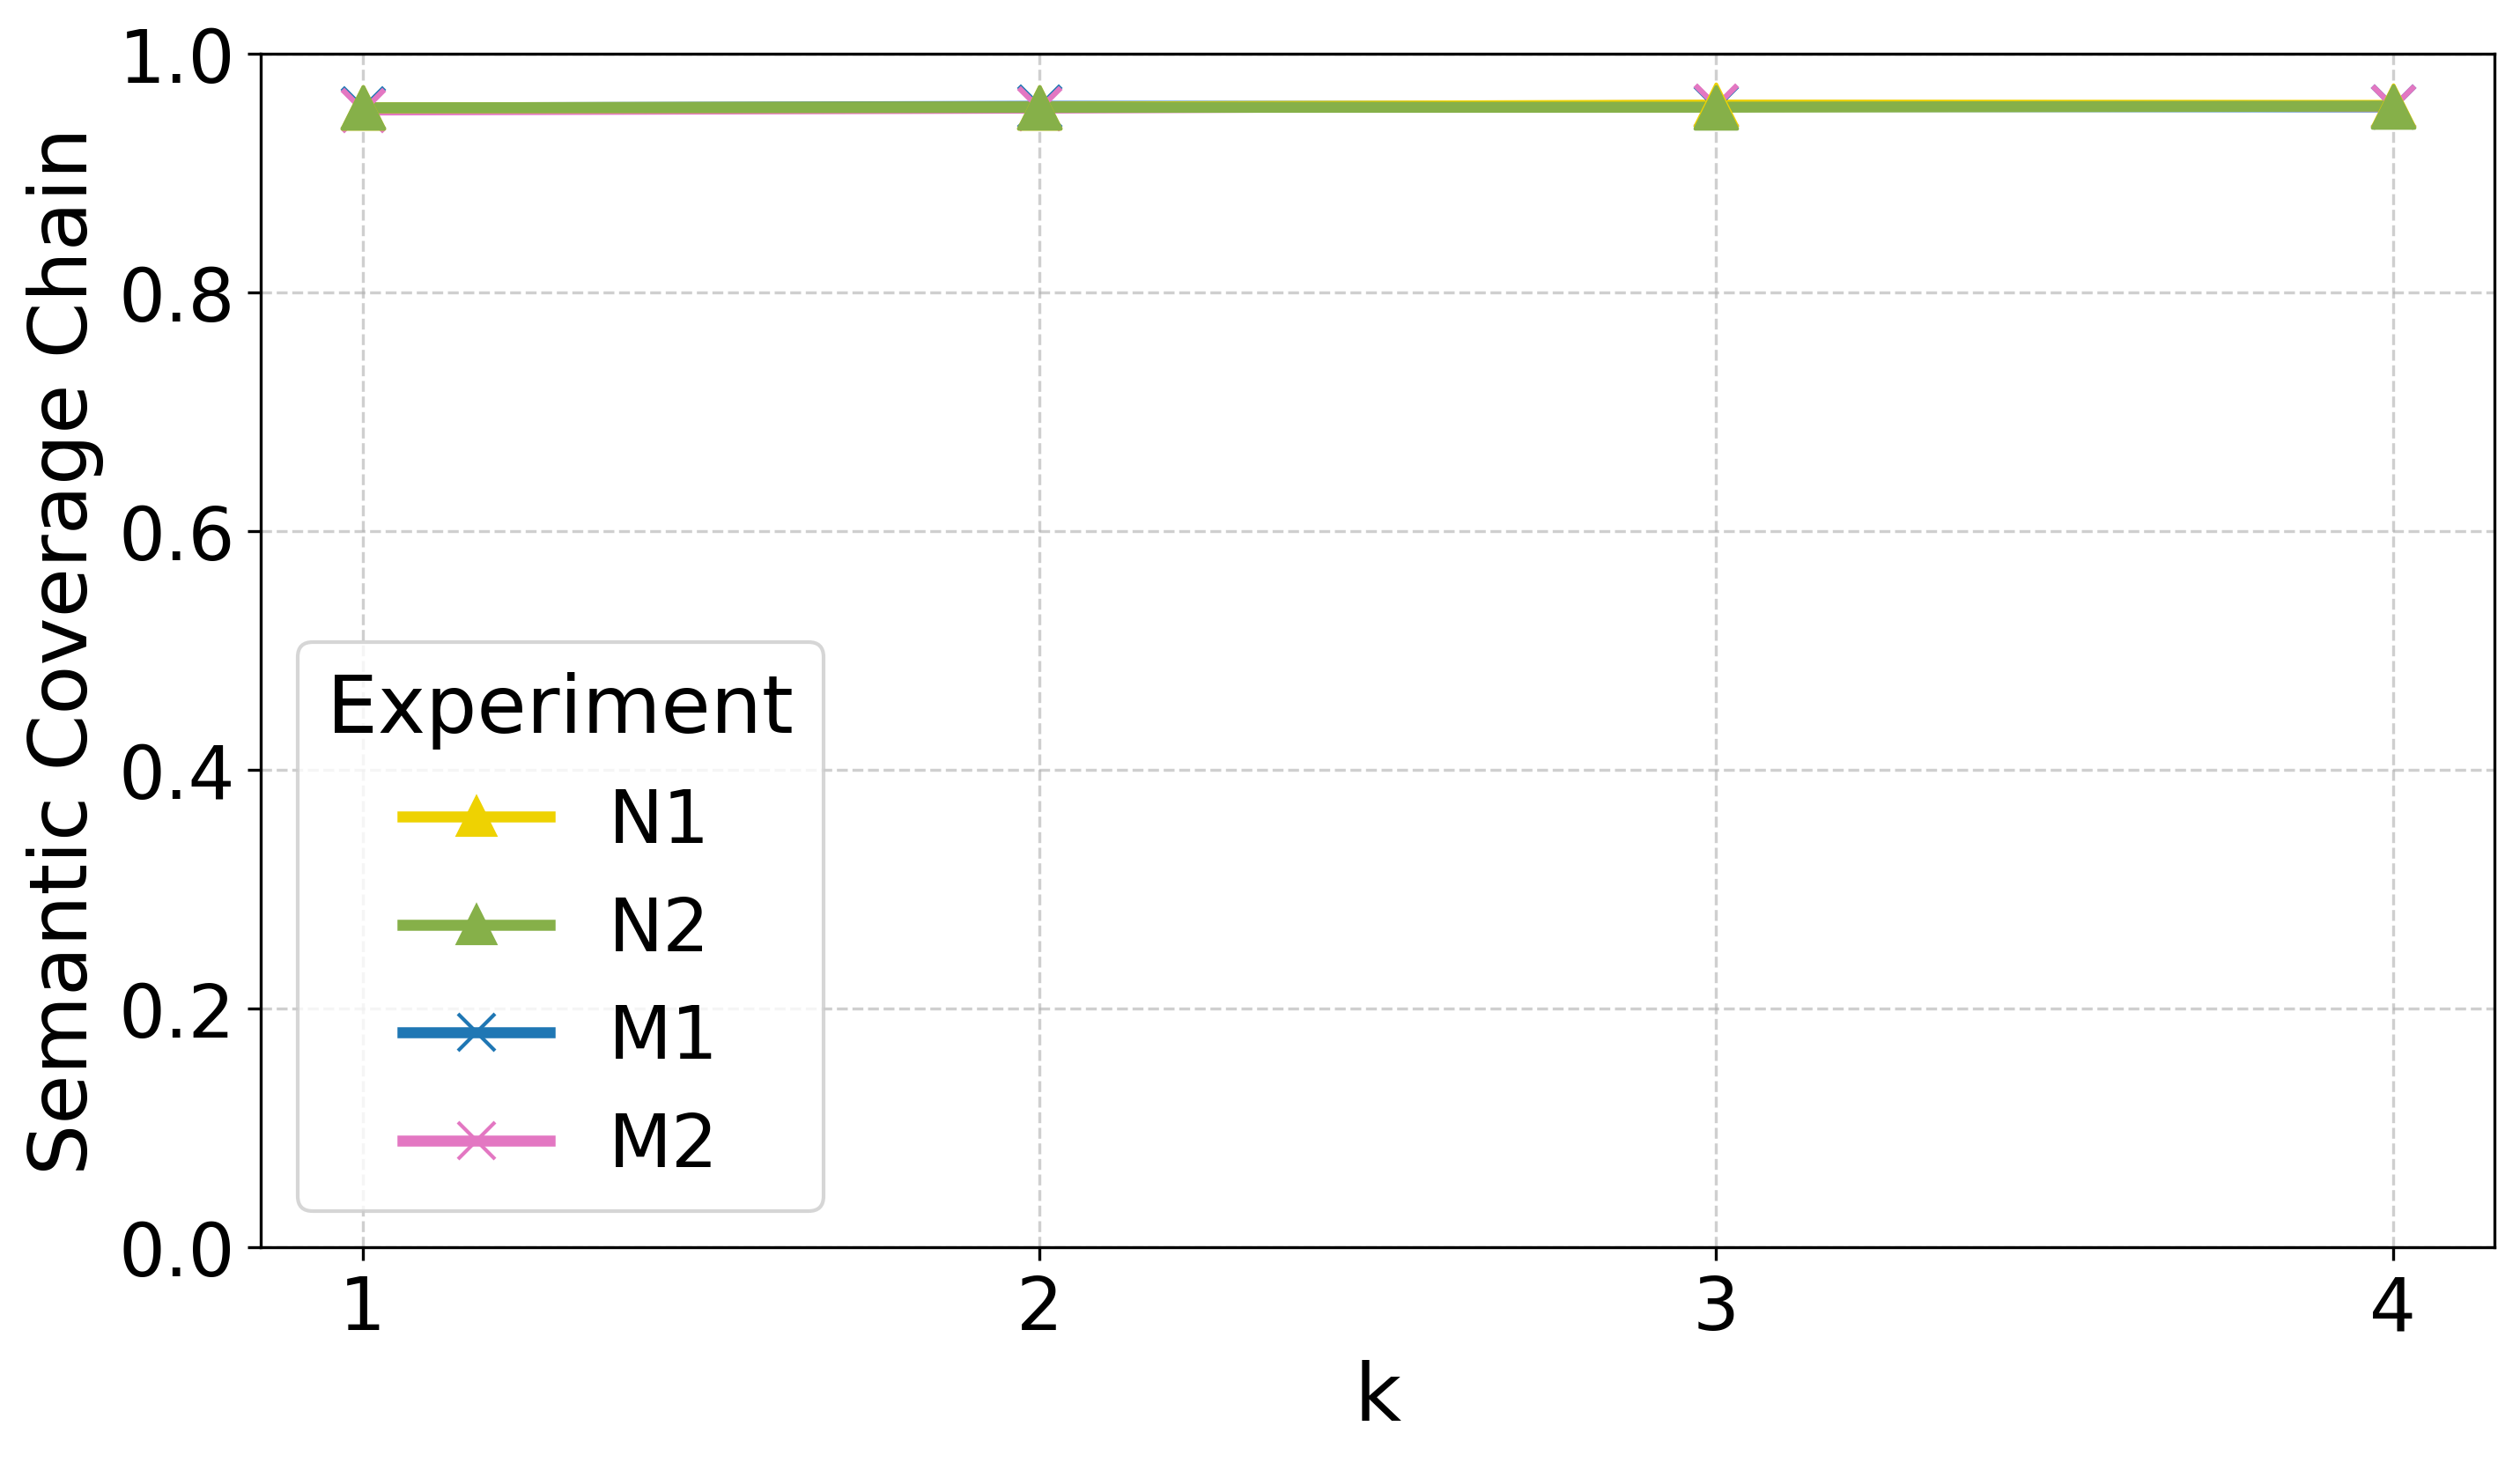

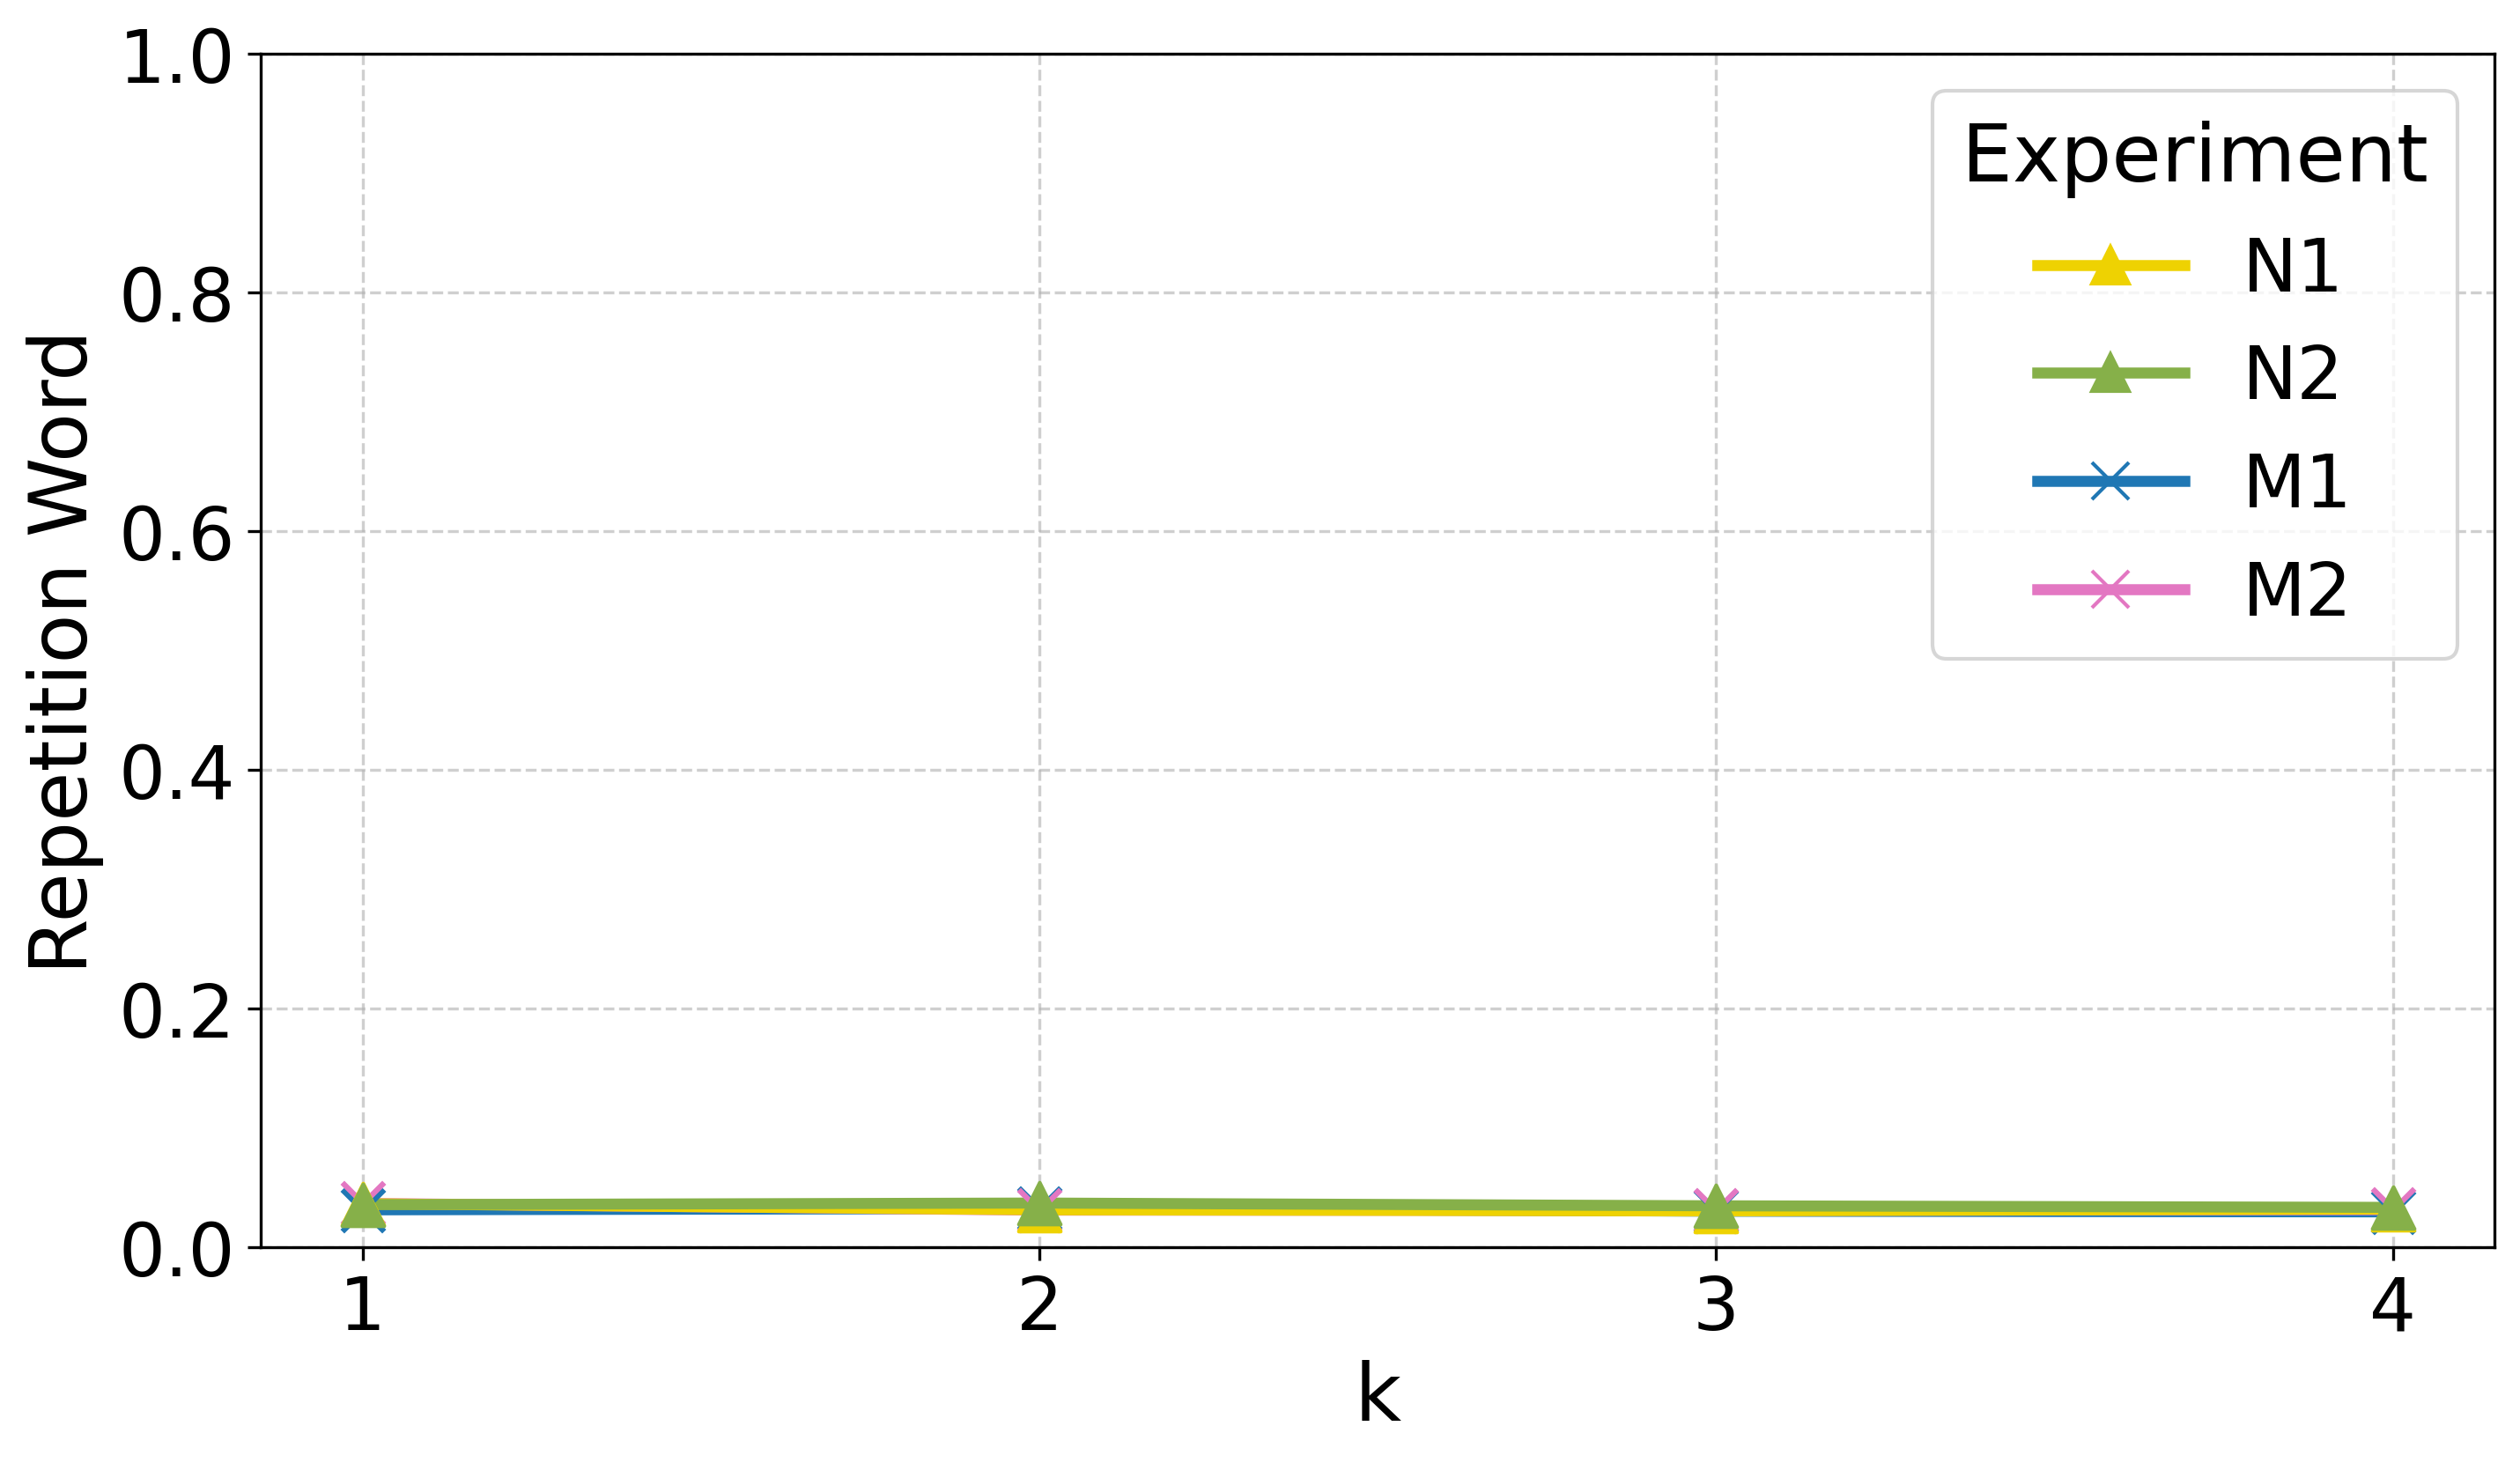

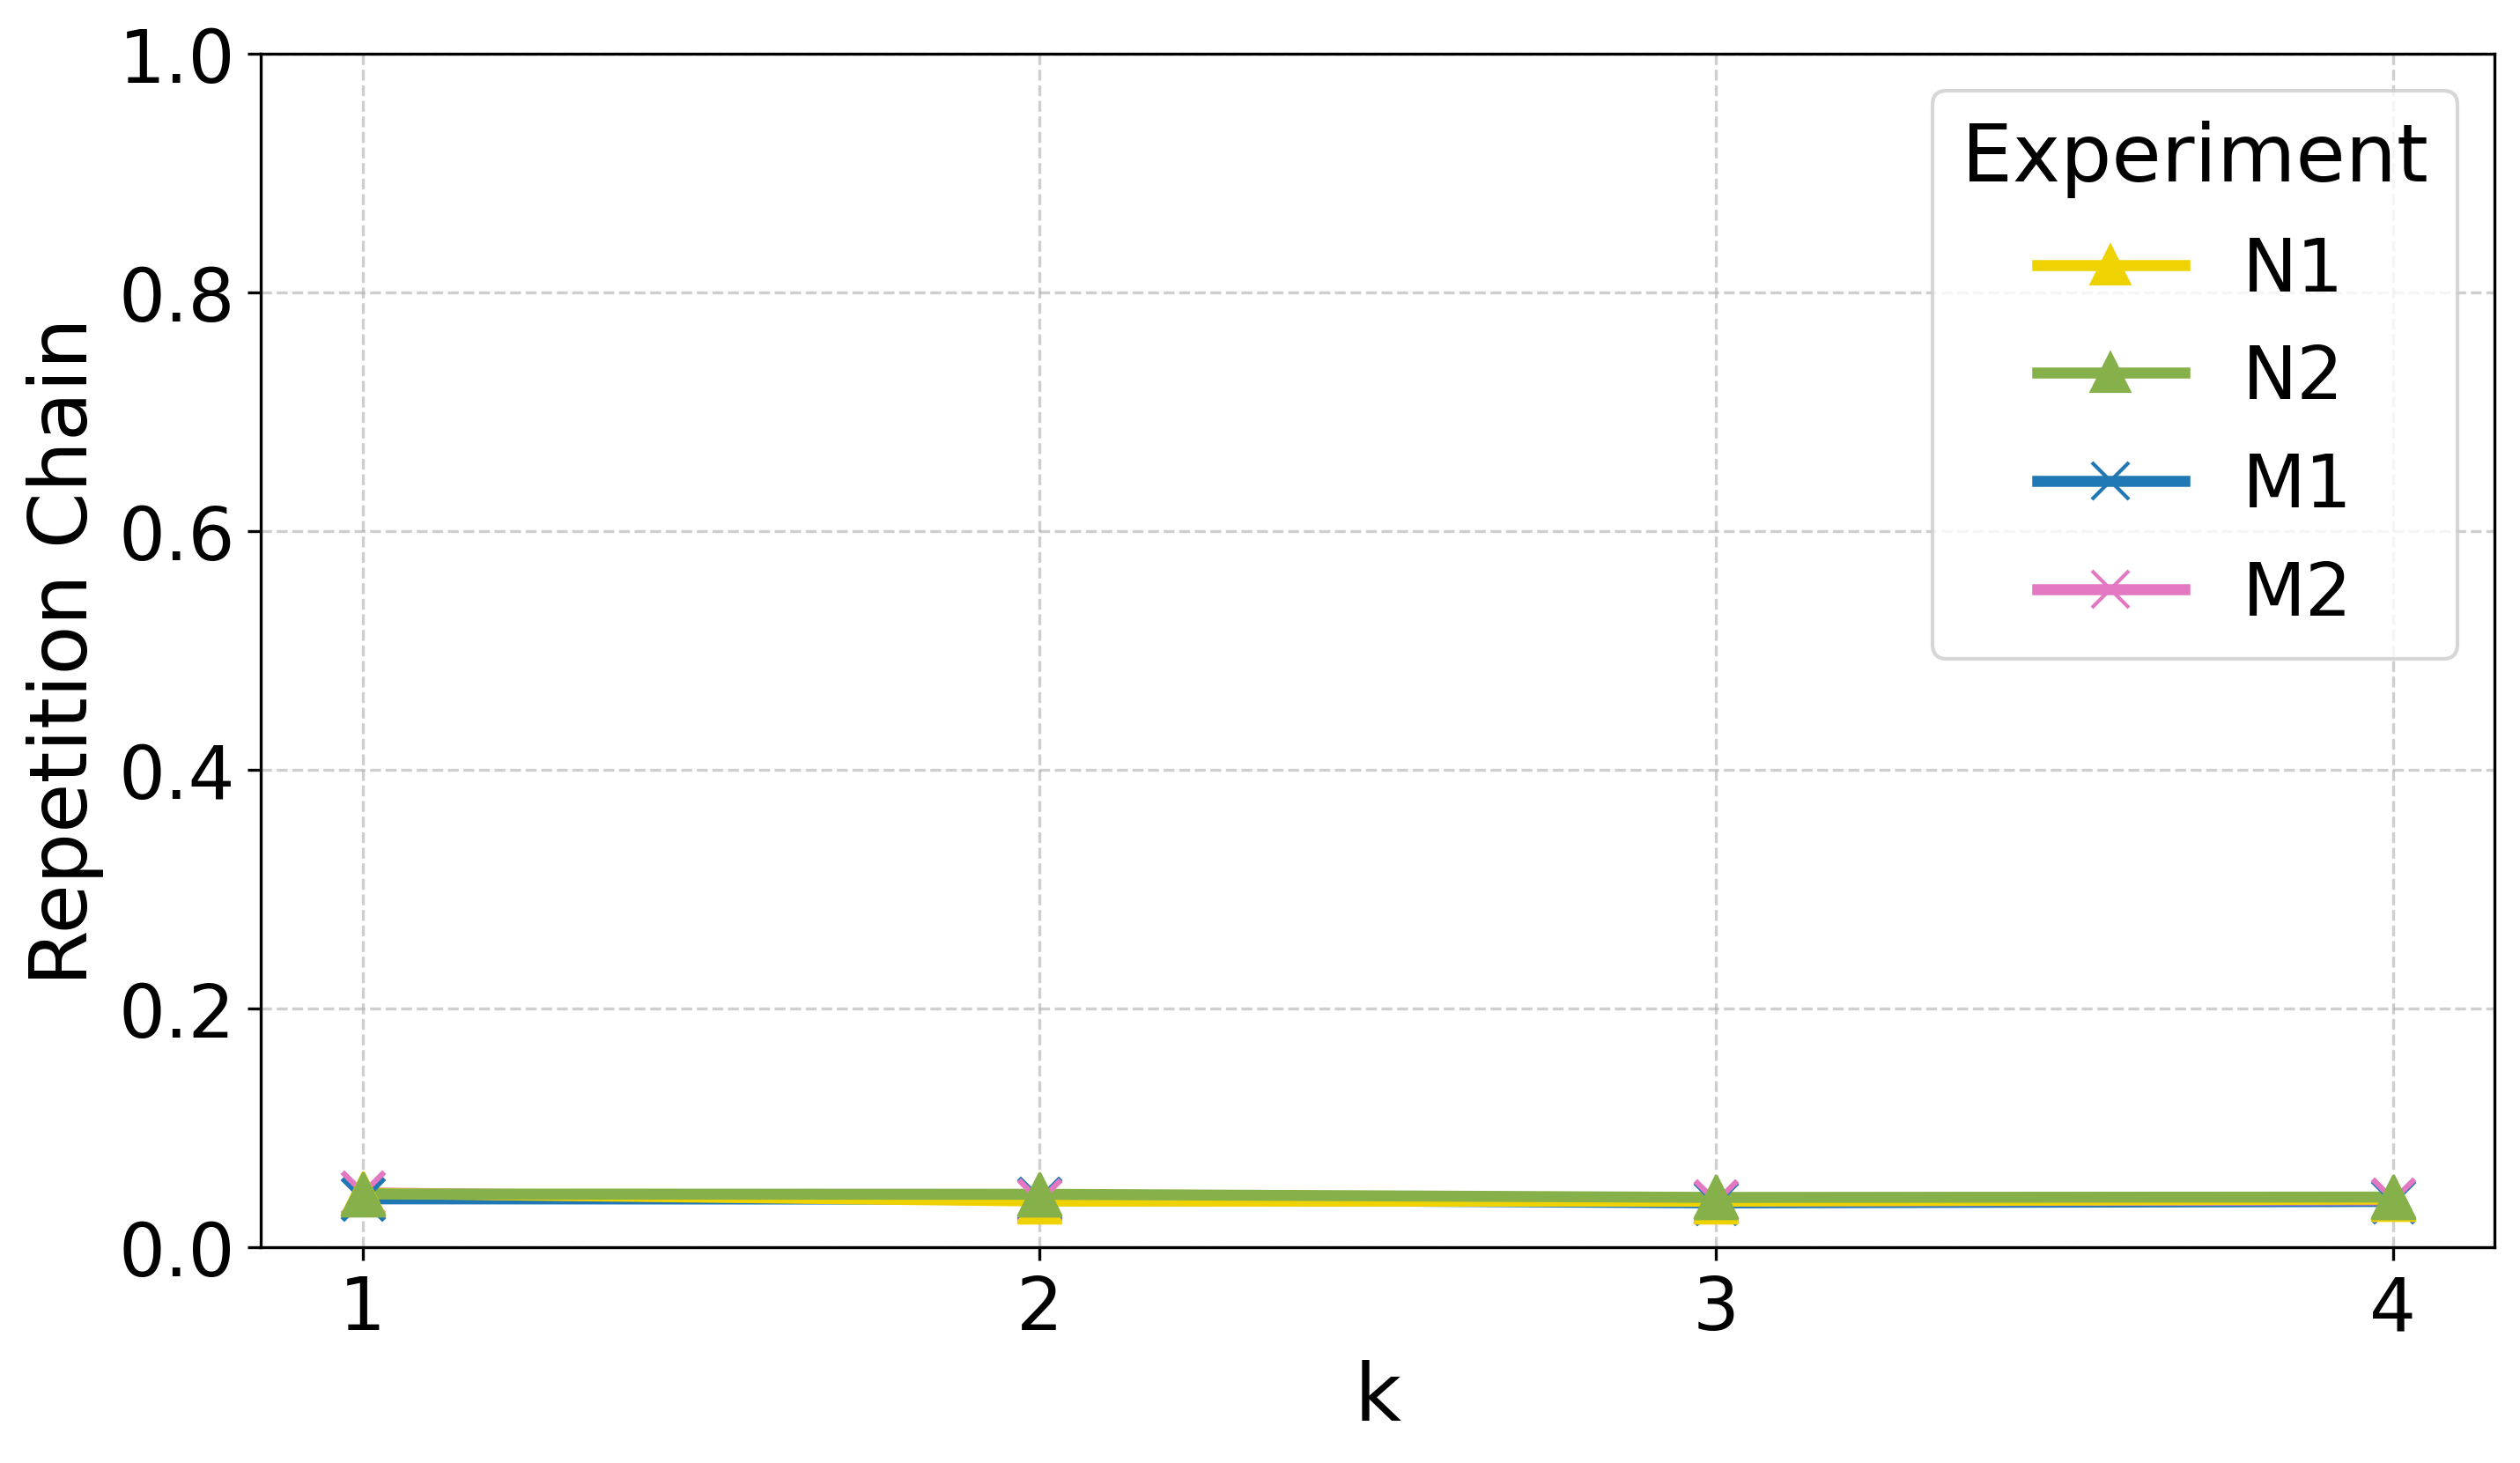

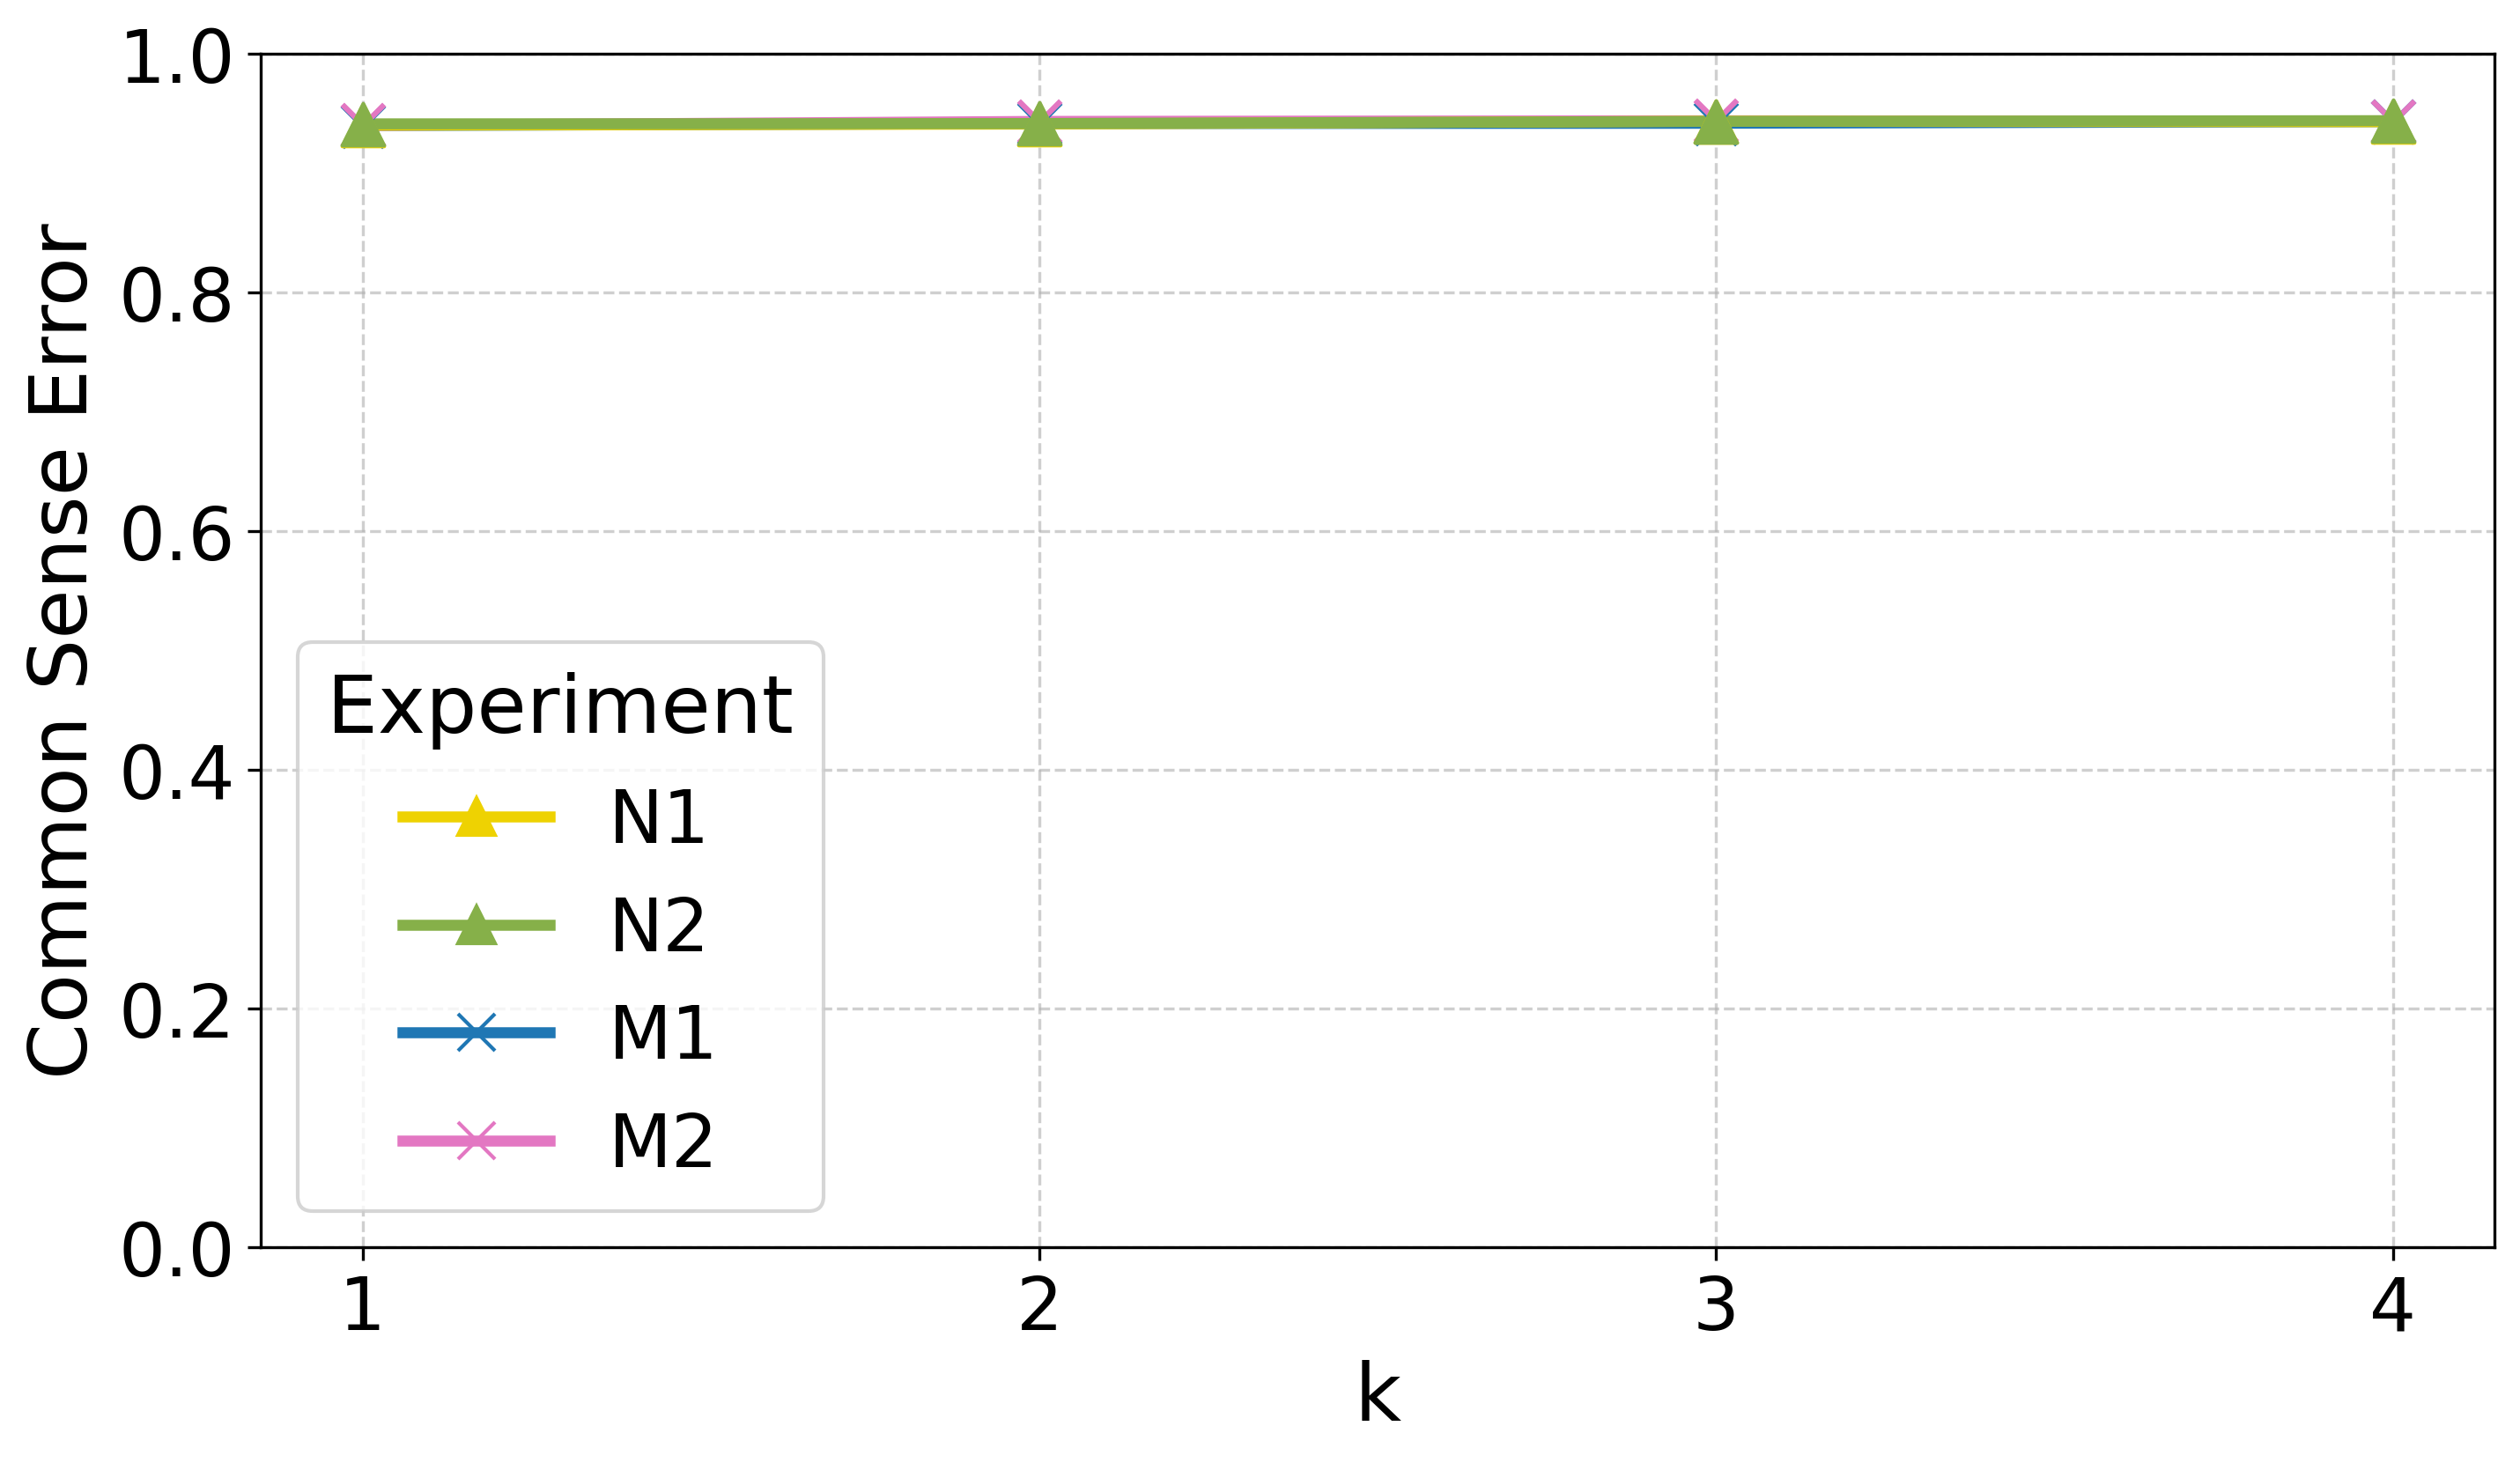

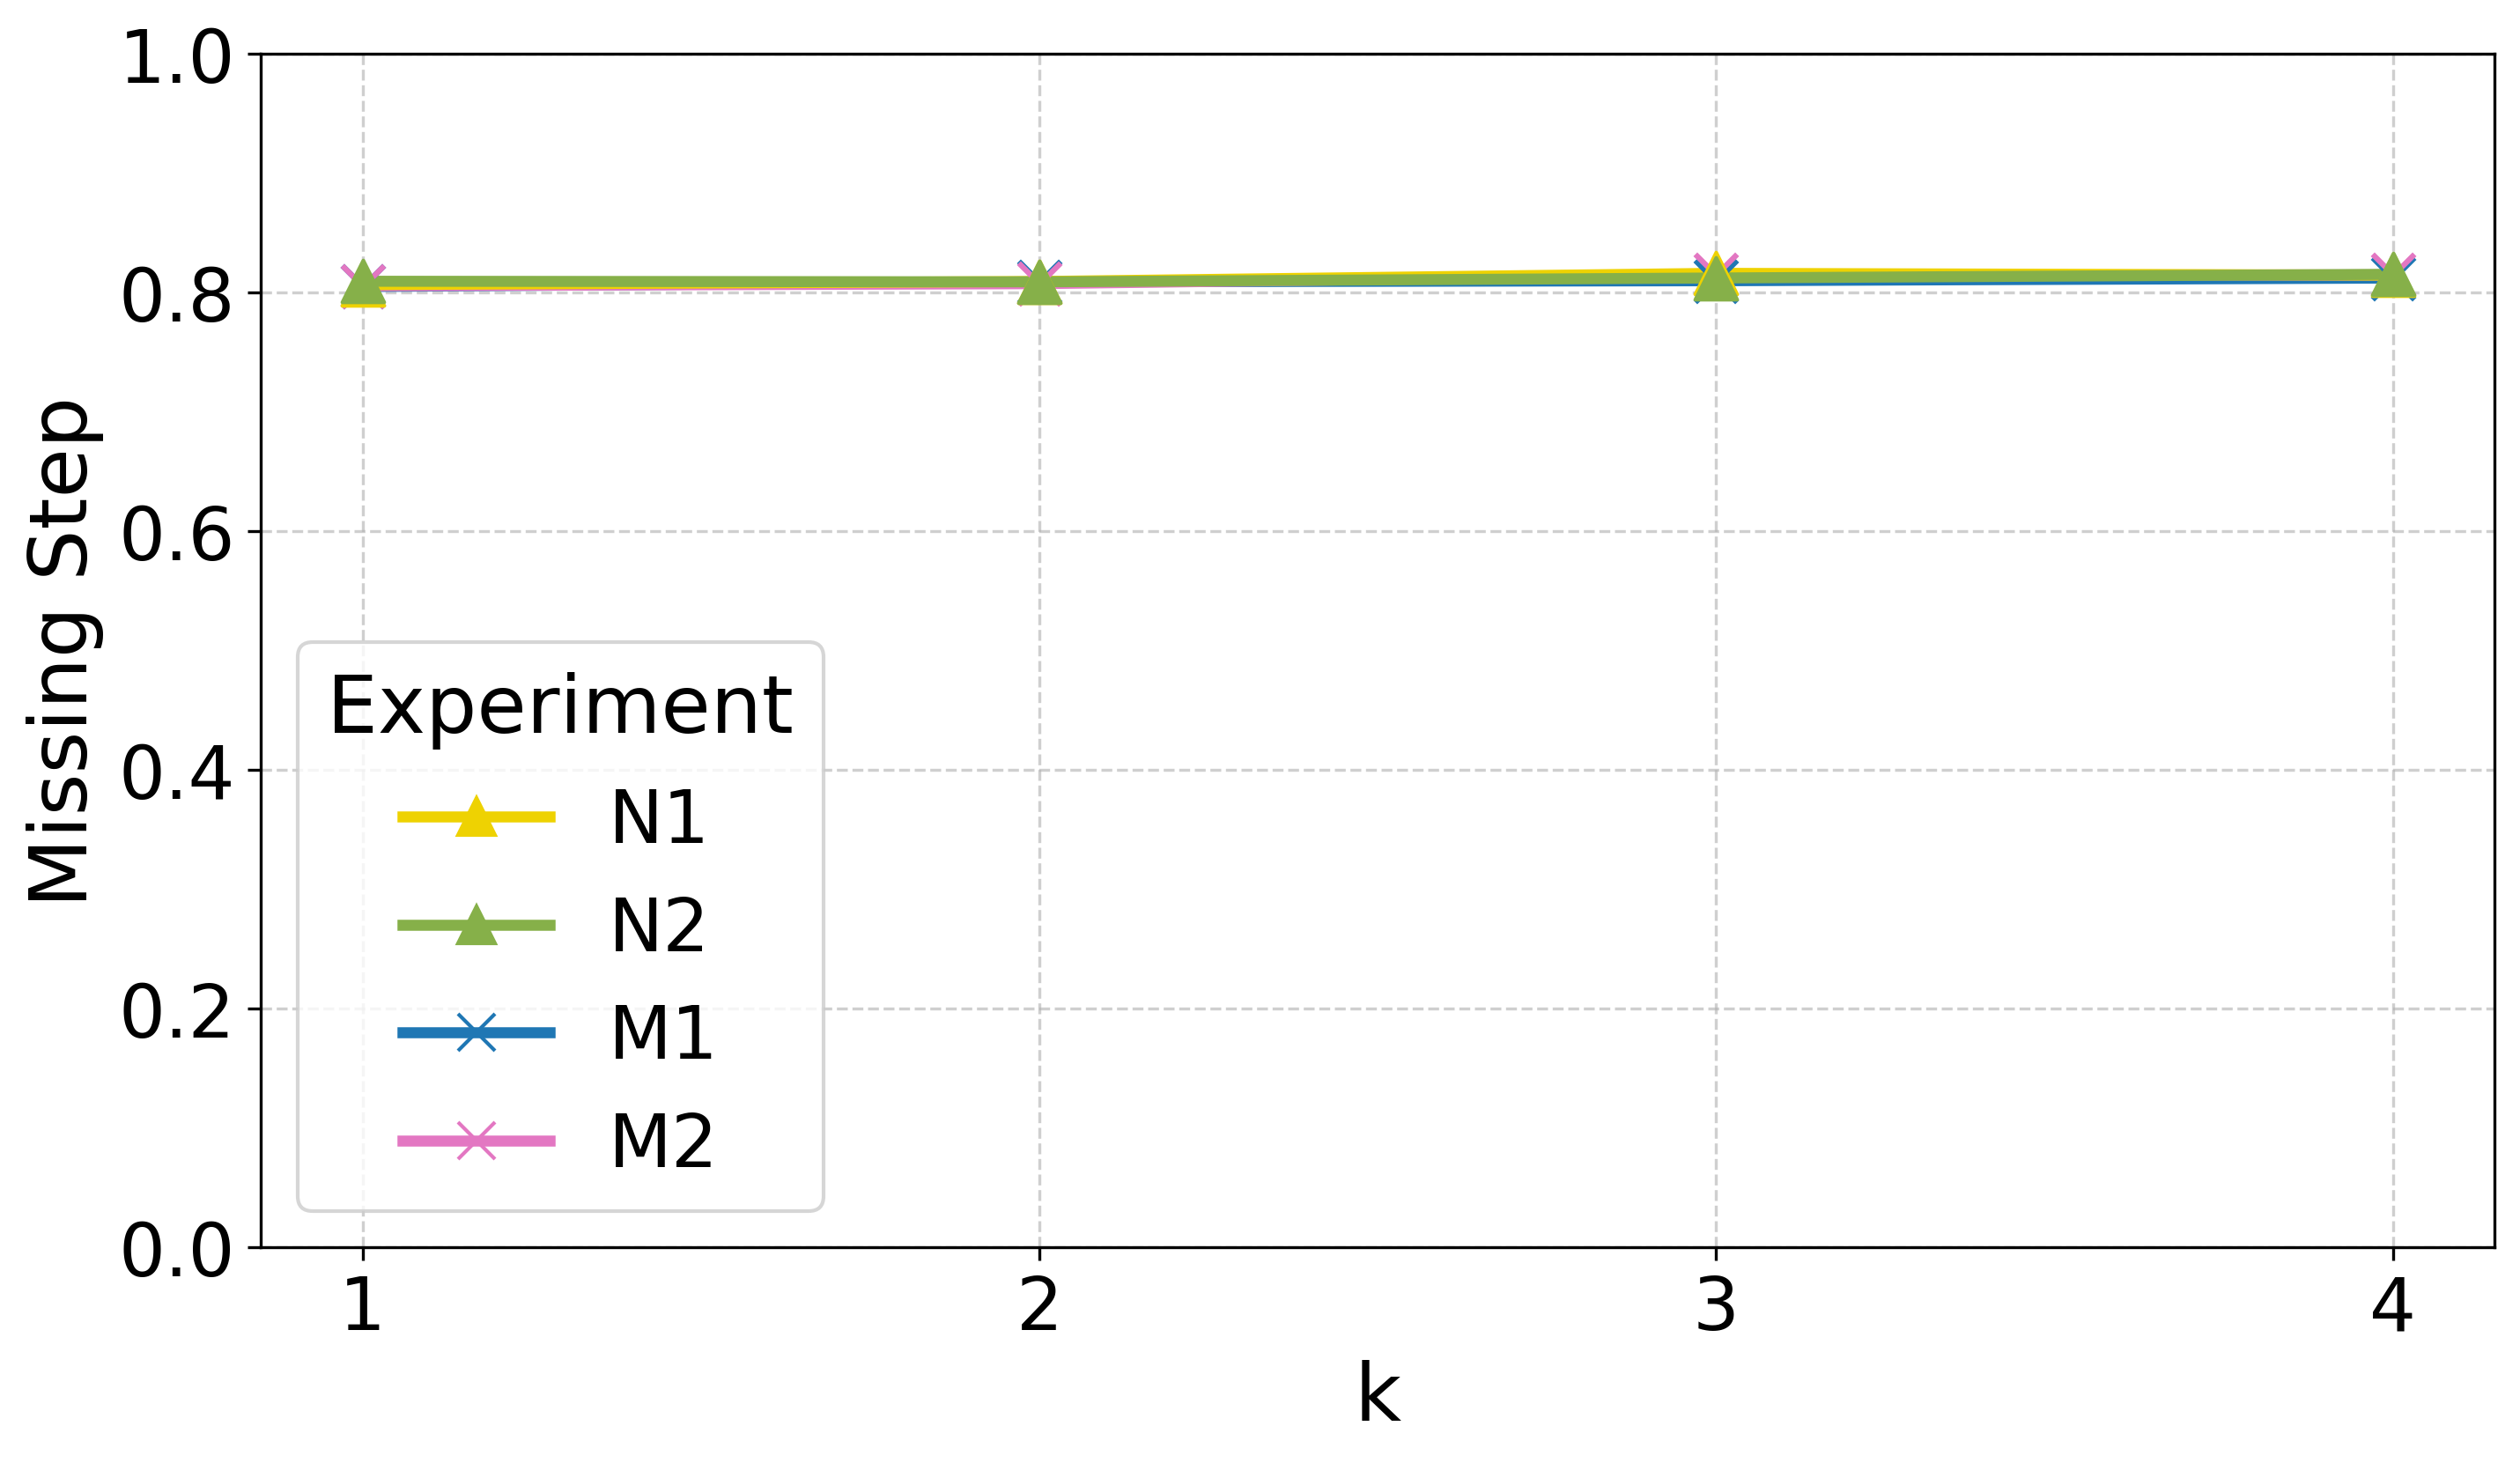

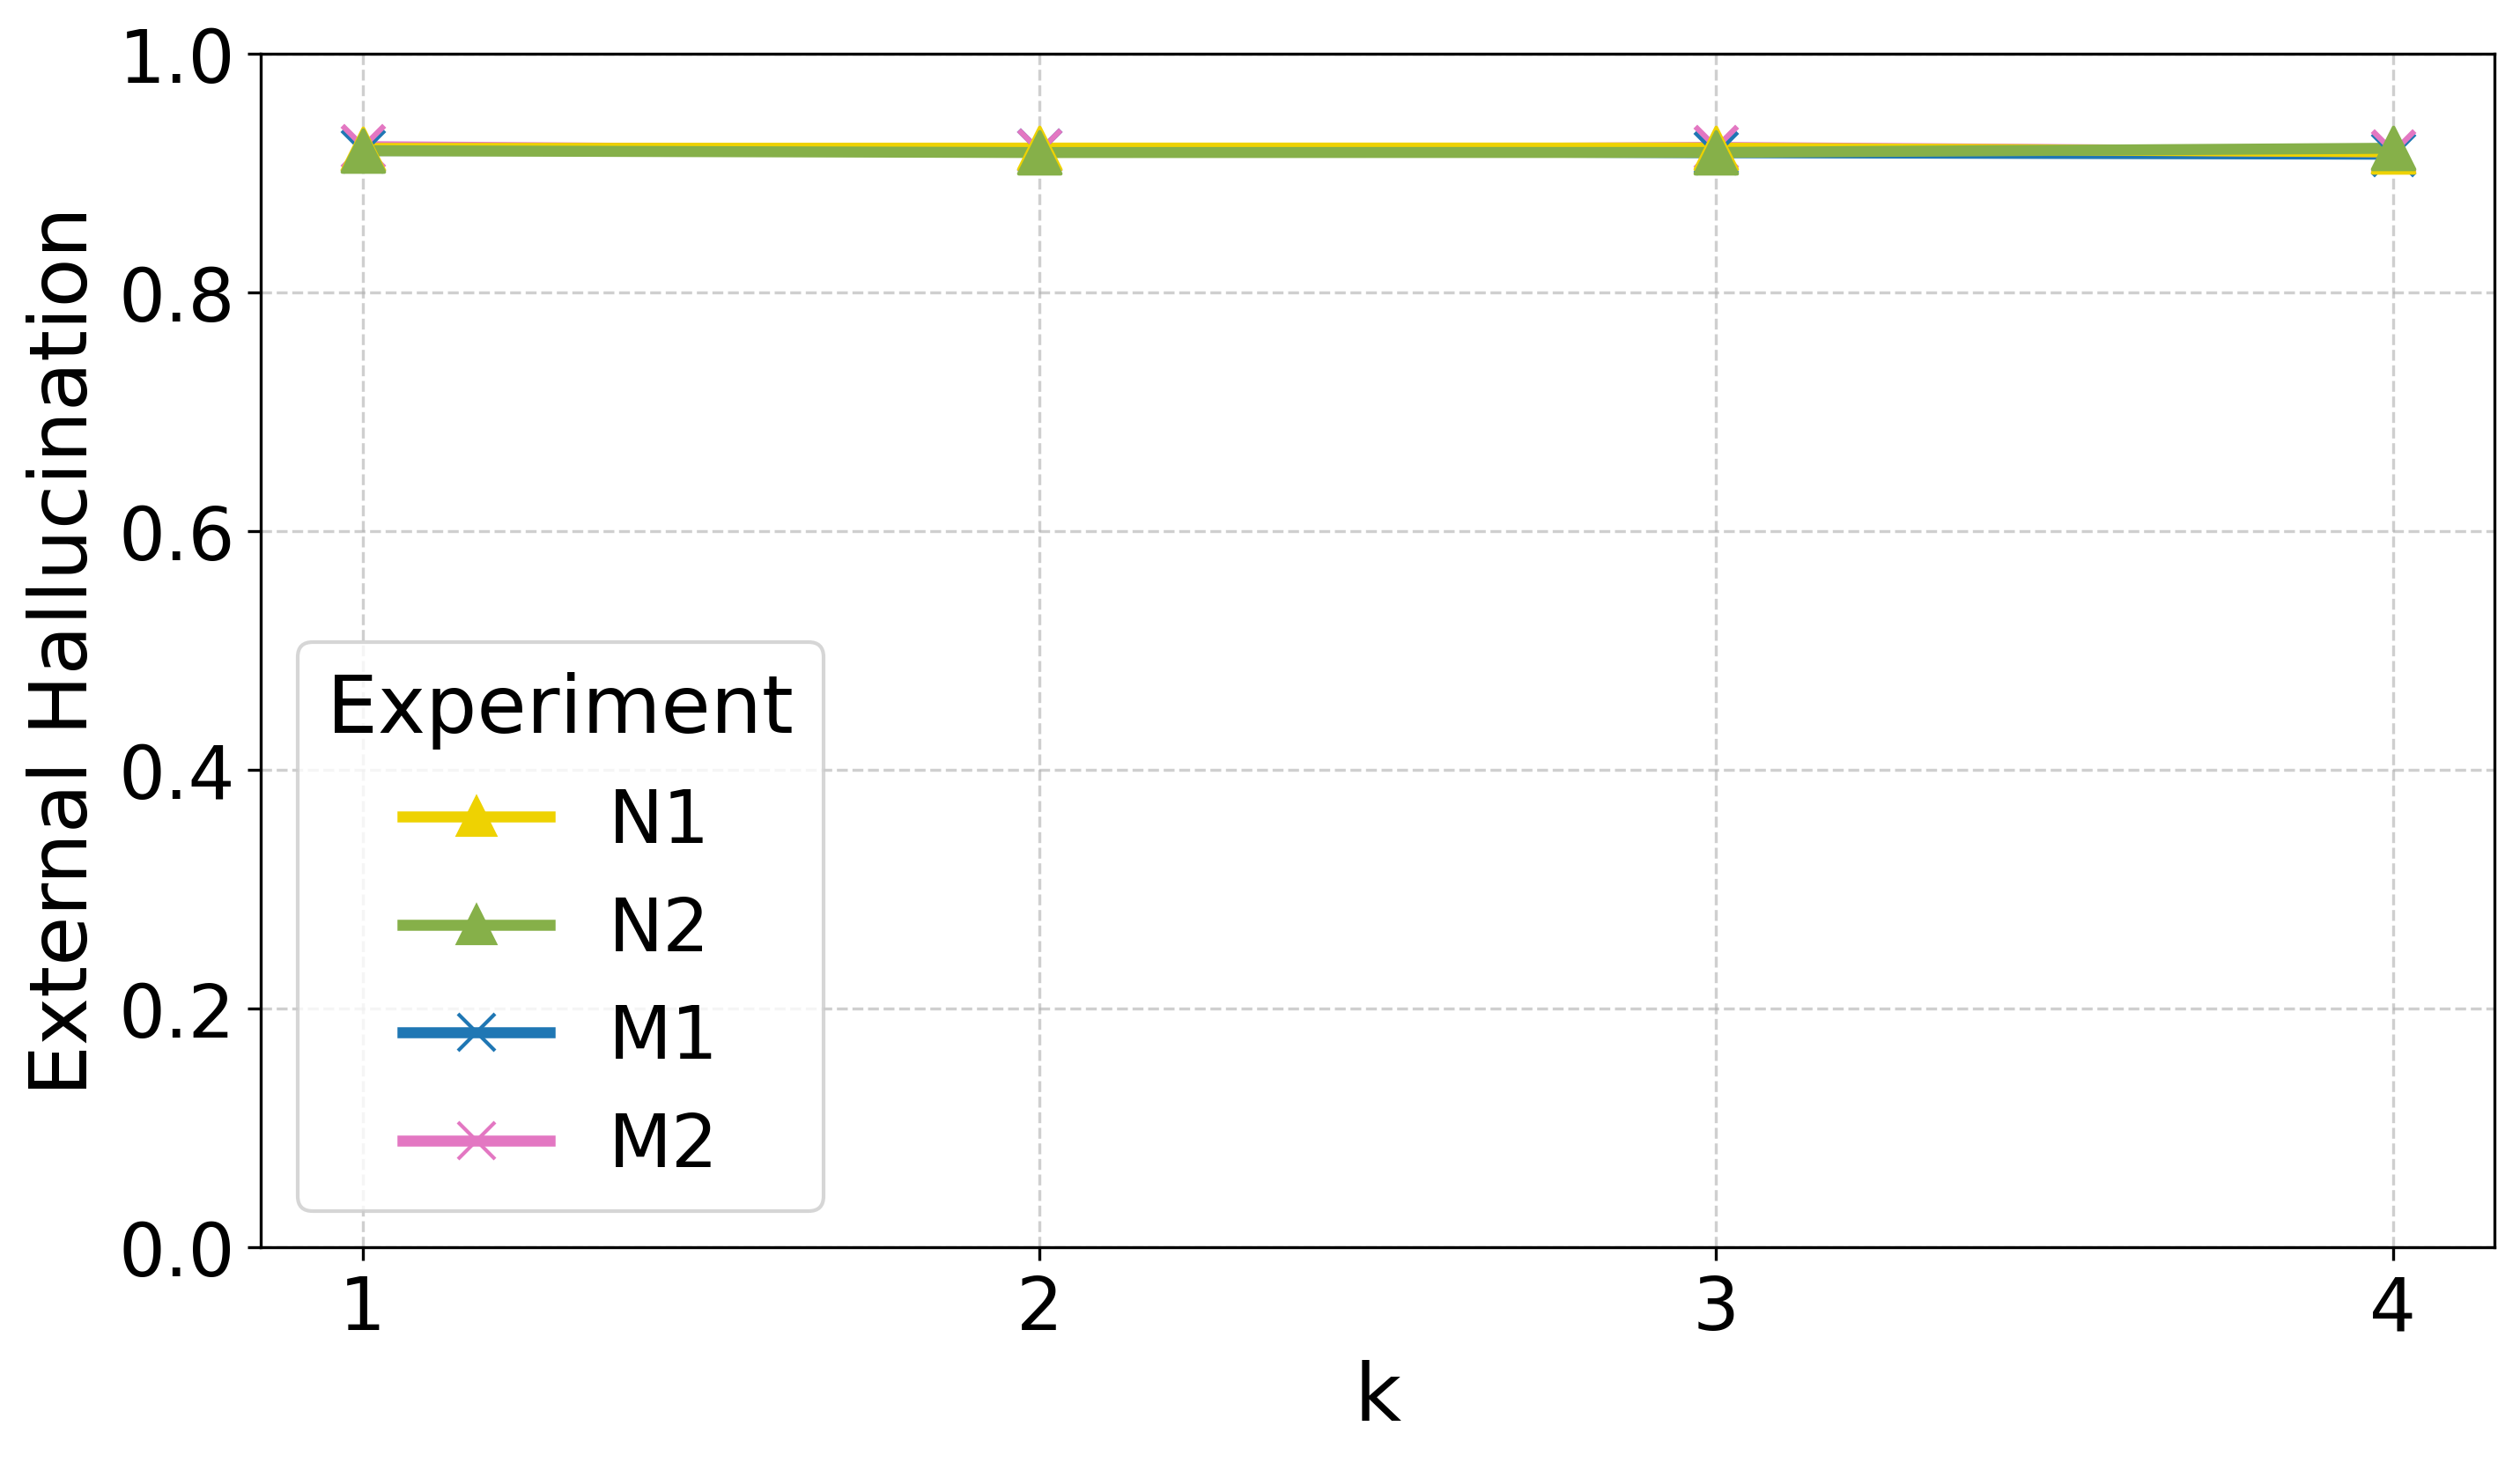

In [12]:
m = ["reasoning_alignment", "semantic_coverage_step", "semantic_coverage_chain", "repetition_word", "repetition_step", "common_sense_error", "missing_step", "external_hallucination"]
ylabels = ["Reasoning Alignment", "Semantic Coverage Step", "Semantic Coverage Chain", "Repetition Word", "Repetition Chain", "Common Sense Error", "Missing Step", "External Hallucination"]
title = [f"{i} per Experimental Configuration" for i in ylabels]

for i in range(len(m)):
    plot_k_curve(metric_file_name=f"_roscoe_results.tsv", metric_column=m[i], ylabel=ylabels[i], title="")

## Plots for report

In [15]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def create_1x4_plot_row(metric_configs):
    fig, axes = plt.subplots(1, len(metric_configs), figsize=(5 * len(metric_configs), 4), sharey=False)

    for ax, (metric_file_name, metric_column, metric_name, ylabel) in zip(axes, metric_configs):
        data = {}

        for exp in experiments:
            if metric_column is None:
                score = compute_accuracy(exp, metric_file_name, metric_name)
            else:
                score = compute_roscoe_metric(exp, metric_file_name, metric_column)

            base = exp[:-2]  # e.g. "n1" from "n1_2"
            k = int(exp.split("_")[1])  # get "2" from "n1_2"
            if base not in data:
                data[base] = {}
            data[base][k] = score

        for base, k_scores in sorted(data.items()):
            ks = sorted(k_scores.keys())
            scores = [k_scores[k] for k in ks]
            color = line_color_map[base]
            marker = "^" if "n" in base else "x"
            ax.plot(ks, scores, label=base.upper(), color=color, linewidth=3)
            ax.scatter(ks, scores, color=color, s=130, zorder=5, marker=marker)

        ax.set_xlabel("k")
        ax.set_ylabel(ylabel)
        ax.set_xticks([1, 2, 3, 4])
        ax.set_ylim(0, 1)
        ax.grid(True, linestyle="--", alpha=0.6)

    # Shared legend (underneath)
    legend_elements = [
        Line2D([0], [0], color=line_color_map[k], marker="^" if "n" in k else "x",
               label=k.upper(), markersize=10, linewidth=3)
        for k in ["n1", "n2", "m1", "m2"]
    ]

    fig.legend(handles=legend_elements,
               title="Experiment",
               loc='lower center',
               ncol=4,
               fontsize='medium',
               frameon=False,
               bbox_to_anchor=(0.5, -0.05))

    # Compact layout with space for the legend
    plt.tight_layout(rect=[0, 0.07, 1, 1])
    plt.subplots_adjust(wspace=0.3)  # compact horizontal spacing
    plt.show()


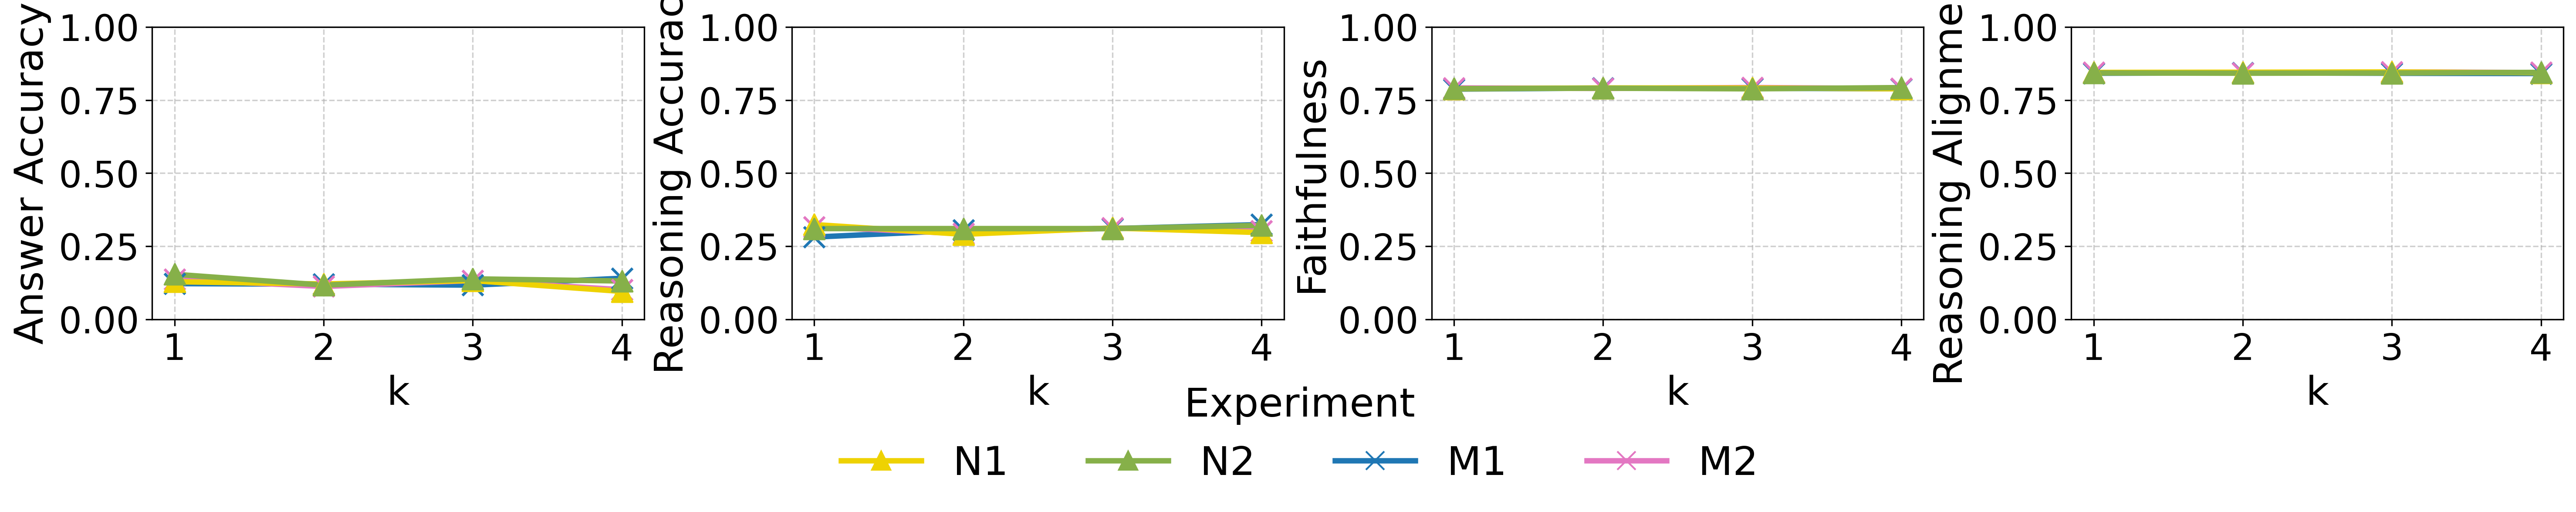

In [16]:
metric_configs = [
        ("_em_results.jsonl", None, "predicted", "Answer Accuracy"),
        ("_llm_comparison_results.jsonl", None, "predicted", "Reasoning Accuracy"),
        ("_roscoe_results.tsv", "faithfulness", None, "Faithfulness"),
        ("_roscoe_results.tsv", "reasoning_alignment", None, "Reasoning Alignment")
    ]
create_1x4_plot_row(metric_configs)